<a href="https://colab.research.google.com/github/Misaelchavez16/Titanic_Machine_Learning_from_Disaster/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imblearn
!pip install missingno
!pip install statsmodels
!pip install missingno==0.5.2

# Titanic Classification

Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as smm
import scipy.stats as stats
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image, display
import requests

This code block defines several functions for plotting various types of distribution and visualization plots to gain insights into our machine learning dataset. The **plot_distribution_plots** function creates histograms and density plots for specified columns, **plot_cross_tabulation** generates cross-tabulation heatmaps between categorical variables and a target variable, **plot_QQ** creates quantile-quantile plots for specified columns to check for normality, scatter_plot_features generates scatter plots for pairwise comparisons of features with different markers for different classes, and plot_QQ_features creates QQ plots for multiple features in a compact layout. These functions are useful for data analysis and understanding the distribution and relationships within the dataset.

In [ ]:
def plot_distribution_plots(df, y, cols, xtickers=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(15, 3))
    counter = 0
    for col in cols:
        if xtickers!=None:
            sns.histplot(data=df, x=col, hue=y, kde=True,bins=len(xtickers[counter]),ax=axes[counter]).legend(["Survived", "Died"])
            hist, bin_edges = np.histogram(df[col], bins=len(xtickers[counter]))
            bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
            axes[counter].set_xticks(bin_midpoints)
            axes[counter].set_xticklabels(xtickers[counter])
        else:
            sns.histplot(data=df, x=col, hue=y, kde=True,ax=axes[counter]).legend(["Survived", "Died"])
        axes[counter].set_title(f'{col} Distribution')
        axes[counter].set_xlabel(f'{col}')
        axes[counter].set_ylabel('Frequency')
        counter += 1
    plt.tight_layout()
    plt.show()

def plot_cross_tabulation(df, y, cols, ytickers):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(15, 5))
    counter = 0
    for col, yticker in zip(cols, ytickers):
        cross_tab = pd.crosstab(train_df[col], train_df[y])

        sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d', ax=axes[counter])
        axes[counter].set_yticklabels(yticker)
        axes[counter].set_xticklabels(["Died", "Survived"])
        axes[counter].set_title(f'Cross-Tabulation {col} vs {y}')
        axes[counter].set_xlabel(y)
        axes[counter].set_ylabel(col)
        counter += 1
    plt.tight_layout()
    plt.show()

def plot_QQ(df, cols):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(15, 5))
    counter = 0
    for col in cols:
        smm.qqplot(df[col], line='s', ax=axes[counter])
        axes[counter].set_title(f'QQ Plot of {col}')
        counter += 1
    plt.show()

def scatter_plot_features(df):
    columns = df.columns

    num_columns = len(columns)

    # Limit the number of figure columns to 5
    num_fig_columns = min(num_columns, 5)

    fig, axes = plt.subplots(nrows=num_columns, ncols=num_fig_columns, figsize=(15, 3 * num_columns))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(num_columns):
        for j in range(num_fig_columns):  # Limit to 5 columns
            if i != j:
                X_column = columns[i]
                Y_column = columns[j]

                # Scatter plot with different markers and colors for "Survived" classes
                dead = df[df["Survived"] == 0]
                alive = df[df["Survived"] == 1]

                axes[i, j].scatter(x=dead[X_column], y=dead[Y_column], marker='o', s=15, c='brown', label="Dead")
                axes[i, j].scatter(x=alive[X_column], y=alive[Y_column], marker='^', s=15, c='blue', label="Alive")

                # Set labels, legends, and titles
                axes[i, j].set_xlabel(X_column)
                axes[i, j].set_ylabel(Y_column)
                axes[i, j].legend()
    plt.tight_layout()
    plt.show()
def plot_QQ_features(df):
    cols = df.columns

    # Determine the number of columns and rows for subplots
    num_columns = len(cols)
    num_rows = int(np.ceil(num_columns / 5))

    # Create a figure with multiple subplots for QQ plots
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for row_idx in range(num_rows):
        for col_idx in range(5):
            subplot_idx = row_idx * 5 + col_idx
            if subplot_idx < num_columns:
                col = cols[subplot_idx]
                smm.qqplot(df[col], line='s', ax=axes[row_idx, col_idx])
                axes[row_idx, col_idx].set_title(f'QQ Plot of {col}')

    # Hide any remaining empty subplots
    for row_idx in range(num_rows):
        for col_idx in range(5):
            subplot_idx = row_idx * 5 + col_idx
            if subplot_idx >= num_columns:
                axes[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

This three datasets are loaded using their respective URLs: the training dataset (train_df) containing information about passengers and their survival outcomes, the test dataset (test_df) for which survival predictions need to be made, and the gender submission dataset (gender_df) which is as a template for submitting predictions.

In [ ]:
train_url = "https://raw.githubusercontent.com/Misaelchavez16/Titanic_Machine_Learning_from_Disaster/main/train.csv"
test_url = "https://raw.githubusercontent.com/Misaelchavez16/Titanic_Machine_Learning_from_Disaster/main/test.csv"


gender_df = pd.read_csv("https://raw.githubusercontent.com/Misaelchavez16/Titanic_Machine_Learning_from_Disaster/main/gender_submission.csv")
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

The dataset consists of various features that provide information about the passengers on the Titanic. Here is a brief overview of these features:

- PassengerId: An identifier for each passenger.
- Survived: A binary variable indicating whether the passenger survived (1) or not (0).
- Pclass: The passenger's class or ticket class (1st, 2nd, or 3rd).
- Name: The name of the passenger.
- Sex: The gender of the passenger (male or female).
- Age: The age of the passenger.
- SibSp: The number of siblings/spouses aboard the Titanic.
- Parch: The number of parents/children aboard the Titanic.
- Ticket: The ticket number.
- Fare: The fare paid for the ticket.
- Cabin: The cabin number where the passenger stayed (if available).
- Embarked: The port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

In [ ]:
train_df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [ ]:
test_df

PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0              330911    7.8292   NaN        Q  
1    female  47.0      1      0              363272    7.0000   NaN        S  
2      male  62.0      0      0              240276    9.6875   NaN        Q  
3      male  27.0      0      0              315154    8.6625   NaN        S  
4    female  22.0      1      1             3101298   12.2875   NaN        S  
..      ...   ...    ...    ...                 ...       ...   ...      ...  
413    male   NaN      0      0           A.5. 3236    8.0500   NaN        S  
414  female  39.0      0      0            PC 17758  108.9000  C105        C  
415    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416    male   NaN      0      0              359309    8.0500   NaN        S  
417    male   NaN      1      1                2668   22.3583   NaN        C  

[418 rows x 11 columns]

In our data preprocessing function, we initiate a series of transformations and treatments on the input DataFrame, df_to_transform. Initially, we craft a new feature known as "Last Name Category" by encoding the passengers' last names. Subsequently, we created a "Family" feature through the combination of details regarding last names, embarked ports, ticket numbers, and fares, and then encode it accordingly. In a similar way, we created a "Traveling Together" feature by merging embarked ports, fares, and ticket numbers. After this, we perform encoding on categorical variables such as "Embarked," "Sex," and "Ticket." We also computed a "Family_Size" attribute by summing "SibSp" and "Parch." After discarding unnecesary columns, we execute K-nearest neighbors (KNN) imputation to manage missing values. Additionally, we round values in the "Age" column, categorize them into specific age brackets, and address outliers employing an outlier detection algorithm. Lastly, we convert some columns into integer data types and ultimately yield the transformed DataFrame, along with a distinct DataFrame intended for testing.

We removed the Cabin column because nearly 80% of the data was missing. Additionally, we excluded the last name and name features, as we had already categorized the last names into a column of categorical last names and a separate column for families.

In [ ]:
# Define a function to categorize age
def categorize_age(age):
    if age < 18:
        return 1
    elif 18 <= age < 24:
        return 2
    elif 24 <= age < 30:
        return 3
    elif 30 <= age < 36:
        return 4
    elif 36 <= age < 41:
        return 5
    else:
        return 6

def handle_outliers(df, column_name, z_threshold=3):
    z_scores = np.abs(stats.zscore(df[column_name]))
    df_outliers_removed = df[(z_scores < z_threshold)]
    return df_outliers_removed

def transform_data_train(df_to_transform, y, knn_imputer, clf, last_name_encoder, family_encoder, traveling_together_encoder, embarked_encoder, sex_encoder, ticket_encoder, title_plot="train", train=False):

    df_to_transform["Last Name"] = df_to_transform["Name"].apply(lambda x: x.split(",")[0].strip())

    df_to_transform.loc[df_to_transform["Fare"] <= 0, "Fare"] = np.nan

    # Plot missing values
    plt.figure()
    msno.matrix(df_to_transform)
    plt.savefig(f"other.png")
    plt.close()

    df_to_transform["Last Name Category"] = last_name_encoder.fit_transform(df_to_transform["Last Name"]) + 1

    df_to_transform["Family"] = df_to_transform["Last Name"] + df_to_transform["Embarked"] + str(df_to_transform["Fare"]) + df_to_transform["Ticket"]
    df_to_transform["Family"] = family_encoder.fit_transform(df_to_transform["Family"]) + 1

    df_to_transform["Traveling Together"] = df_to_transform["Embarked"] + df_to_transform["Fare"].astype(str) + df_to_transform["Ticket"]
    df_to_transform["Traveling Together"] = traveling_together_encoder.fit_transform(df_to_transform["Traveling Together"]) + 1

    df_to_transform["Embarked"] = embarked_encoder.fit_transform(df_to_transform["Embarked"]) + 1
    df_to_transform.loc[df_to_transform["Embarked"] == 4, "Embarked"] = np.nan

    df_to_transform["Sex"] = sex_encoder.fit_transform(df_to_transform["Sex"]) + 1

    df_to_transform["Ticket"] = ticket_encoder.fit_transform(df_to_transform["Ticket"]) + 1

    df_to_transform["Family_Size"] = df_to_transform["SibSp"] + df_to_transform["Parch"]

    df_to_transform["SibSp"] = df_to_transform["SibSp"] + 1
    df_to_transform["Parch"] = df_to_transform["Parch"] + 1

    df_to_transform["Family_Size"] = df_to_transform["Family_Size"] + 1

    # Remove unncessary columns
    df_to_transform = df_to_transform.drop(["Name", "Cabin", "Last Name"], axis=1)

    # Plot missing values
    plt.figure()
    msno.matrix(df_to_transform)
    plt.title("Missing samples on dataset")
    plt.savefig(f"missing_1_{title_plot}.png")
    plt.close()

    # KNN imputer
    df_to_transform = pd.DataFrame(knn_imputer.fit_transform(df_to_transform.to_numpy()), columns=df_to_transform.columns)
    df_to_transform.index = df_to_transform.index + 1

    # Plot missing values
    plt.figure()
    msno.matrix(df_to_transform)
    plt.savefig(f"missing_2_{title_plot}.png")
    plt.title("Dataset with imputed samples - KNN")
    plt.close()

    df_to_transform['Age'] = df_to_transform['Age'].apply(np.round)
    df_to_transform.loc[df_to_transform["Age"] == 0, "Age"] = 1
    df_to_transform['Age_Category'] = df_to_transform['Age'].apply(categorize_age)

    dataframe_test = df_to_transform.copy().loc[892:1309]
    df_to_transform = df_to_transform.copy().loc[1:891]

    df_to_transform["Survived"] = y["Survived"]

    # Outliers handling
    for column_name in df_to_transform.columns:
        df_to_transform = handle_outliers(df_to_transform, column_name)

    outlier_labels = clf.fit_predict(df_to_transform)
    df_to_transform = df_to_transform[outlier_labels == 1]

    convert_dict = {
                'Pclass': int,
                'Sex':int,
                'SibSp':int,
                'Parch':int,
                'Ticket':int,
                'Embarked':int,
                'Last Name Category':int,
                'Family':int,
                'Traveling Together': int,
                'Family_Size':int,
                }
    df_to_transform = df_to_transform.astype(convert_dict)

    return df_to_transform, dataframe_test

In this block of code, we are preparing and transforming the data for our machine learning model. We set up a K-nearest neighbors (KNN) imputer and an Isolation Forest classifier for handling missing values and detecting outliers, respectively. We also initialize several LabelEncoders to encode categorical features. The target variable 'Survived' is separated from the training dataset, and the training and test datasets are combined into one DataFrame. We then use the 'transform_data_train' function to perform a series of data transformations, including feature engineering, encoding, handling missing values, and outlier detection. This prepares the data for further analysis and modeling, ensuring it is in a suitable format for training and evaluation.

We opt to categorize the age of the passengers as follows: under 18 = 0, 18-23 = 1, 24-29 = 2, 30-35 = 3, 36-40 = 4, and above 40 = 5.

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
clf = IsolationForest(contamination=0.05, random_state=42)

last_name_encoder = LabelEncoder()
family_encoder = LabelEncoder()
traveling_together_encoder = LabelEncoder()
embarked_encoder = LabelEncoder()
sex_encoder = LabelEncoder()
ticket_encoder = LabelEncoder()

y = train_df[["PassengerId", "Survived"]]
y.set_index("PassengerId", inplace=True)
combined_data = pd.concat([train_df.drop(["Survived"], axis=1), test_df], ignore_index=True)
combined_data.set_index("PassengerId", inplace=True)
train_df, test_df = transform_data_train(combined_data, y, knn_imputer, clf, last_name_encoder, family_encoder, traveling_together_encoder, embarked_encoder, sex_encoder, ticket_encoder, title_plot="train", train=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
train_df

Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  Embarked  \
1         3    2  22.0      2      1     721   7.2500         3   
2         1    1  38.0      2      1     817  71.2833         1   
3         3    1  26.0      1      1     915   7.9250         3   
4         1    1  35.0      2      1      66  53.1000         3   
5         3    2  35.0      1      1     650   8.0500         3   
..      ...  ...   ...    ...    ...     ...      ...       ...   
887       2    2  27.0      1      1     131  13.0000         3   
888       1    1  19.0      1      1      19  30.0000         3   
889       3    1  33.0      2      3     924  23.4500         3   
890       1    2  26.0      1      1      12  30.0000         1   
891       3    2  32.0      1      1     643   7.7500         2   

     Last Name Category  Family  Traveling Together  Family_Size  \
1                   101     119                 620            2   
2                   183     222                 155            2   
3                   330     405                 783            1   
4                   268     328                 577            2   
5                    16      19                 814            1   
..                  ...     ...                 ...          ...   
887                 536     641                 334            1   
888                 295     358                 526            1   
889                 384     470                 455            4   
890                  70      81                  69            1   
891                 215     261                 244            1   

     Age_Category  Survived  
1               2         0  
2               5         1  
3               3         1  
4               4         1  
5               4         0  
..            ...       ...  
887             3         0  
888             2         1  
889             4         0  
890             3         1  
891             4         0  

[769 rows x 14 columns]

In [ ]:
test_df

Pclass  Sex   Age  SibSp  Parch  Ticket      Fare  Embarked  \
892      3.0  2.0  34.0    1.0    1.0   377.0    7.8292       2.0   
893      3.0  1.0  47.0    2.0    1.0   583.0    7.0000       3.0   
894      2.0  2.0  62.0    1.0    1.0   185.0    9.6875       2.0   
895      3.0  2.0  27.0    1.0    1.0   367.0    8.6625       3.0   
896      3.0  1.0  22.0    2.0    2.0   339.0   12.2875       3.0   
...      ...  ...   ...    ...    ...     ...       ...       ...   
1305     3.0  2.0  20.0    1.0    1.0   712.0    8.0500       3.0   
1306     1.0  1.0  39.0    1.0    1.0   835.0  108.9000       1.0   
1307     3.0  2.0  38.0    1.0    1.0   873.0    7.2500       3.0   
1308     3.0  2.0  30.0    1.0    1.0   580.0    8.0500       3.0   
1309     3.0  2.0  18.0    2.0    2.0   263.0   22.3583       1.0   

      Last Name Category  Family  Traveling Together  Family_Size  \
892                402.0   496.0               262.0          1.0   
893                847.0   989.0               596.0          2.0   
894                553.0   662.0               277.0          1.0   
895                855.0  1000.0               879.0          1.0   
896                343.0   418.0               325.0          3.0   
...                  ...     ...                 ...          ...   
1305               754.0   884.0               826.0          1.0   
1306               594.0   707.0                 2.0          1.0   
1307               700.0   826.0               628.0          1.0   
1308               828.0   965.0               806.0          1.0   
1309               635.0   755.0                41.0          3.0   

      Age_Category  
892              4  
893              6  
894              6  
895              3  
896              2  
...            ...  
1305             2  
1306             5  
1307             5  
1308             4  
1309             2  

[418 rows x 13 columns]

In [ ]:
combined_data

Pclass                                               Name  Sex  \
PassengerId                                                                   
1                 3                            Braund, Mr. Owen Harris    2   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1   
3                 3                             Heikkinen, Miss. Laina    1   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1   
5                 3                           Allen, Mr. William Henry    2   
...             ...                                                ...  ...   
1305              3                                 Spector, Mr. Woolf    2   
1306              1                       Oliva y Ocana, Dona. Fermina    1   
1307              3                       Saether, Mr. Simon Sivertsen    2   
1308              3                                Ware, Mr. Frederick    2   
1309              3                           Peter, Master. Michael J    2   

              Age  SibSp  Parch  Ticket      Fare Cabin  Embarked  \
PassengerId                                                         
1            22.0      2      1     721    7.2500   NaN       3.0   
2            38.0      2      1     817   71.2833   C85       1.0   
3            26.0      1      1     915    7.9250   NaN       3.0   
4            35.0      2      1      66   53.1000  C123       3.0   
5            35.0      1      1     650    8.0500   NaN       3.0   
...           ...    ...    ...     ...       ...   ...       ...   
1305          NaN      1      1     712    8.0500   NaN       3.0   
1306         39.0      1      1     835  108.9000  C105       1.0   
1307         38.5      1      1     873    7.2500   NaN       3.0   
1308          NaN      1      1     580    8.0500   NaN       3.0   
1309          NaN      2      2     263   22.3583   NaN       1.0   

                 Last Name  Last Name Category  Family  Traveling Together  \
PassengerId                                                                  
1                   Braund                 101     119                 620   
2                  Cumings                 183     222                 155   
3                Heikkinen                 330     405                 783   
4                 Futrelle                 268     328                 577   
5                    Allen                  16      19                 814   
...                    ...                 ...     ...                 ...   
1305               Spector                 754     884                 826   
1306         Oliva y Ocana                 594     707                   2   
1307               Saether                 700     826                 628   
1308                  Ware                 828     965                 806   
1309                 Peter                 635     755                  41   

             Family_Size  
PassengerId               
1                      2  
2                      2  
3                      1  
4                      2  
5                      1  
...                  ...  
1305                   1  
1306                   1  
1307                   1  
1308                   1  
1309                   3  

[1309 rows x 15 columns]

In this block of code, we are creating ratio features based on the correlation between pairs of columns in the training dataset (train_df). We calculate the correlation matrix and then set a threshold (in this case, ±0.25) to identify pairs of columns that have a correlation exceeding this threshold. For each identified pair, we generate a new ratio feature by dividing one column by the other. These ratio features capture potential interactions or relationships between the original columns and can be used as additional features for our machine learning models to potentially improve their performance.

In [ ]:
def create_ratios(train_df):
    correlation_matrix = X_res.corr()
    threshold = 0.25

    # Initialize list to store pairs of cols
    column_pairs = []

    # Find pairs of columns with correlations of -0.25 and +0.25
    for i in range(len(correlation_matrix.columns) - 1):
        for j in range(i + 1, len(correlation_matrix.columns) - 1):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:

                column_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Create new ratio features for the identified pairs
    for col1, col2 in column_pairs:
        new_feature_name = f"{col1}_{col2}_ratio"
        X_res[new_feature_name] = X_res[col1] / X_res[col2]

## 1. Explore and data preprocessing

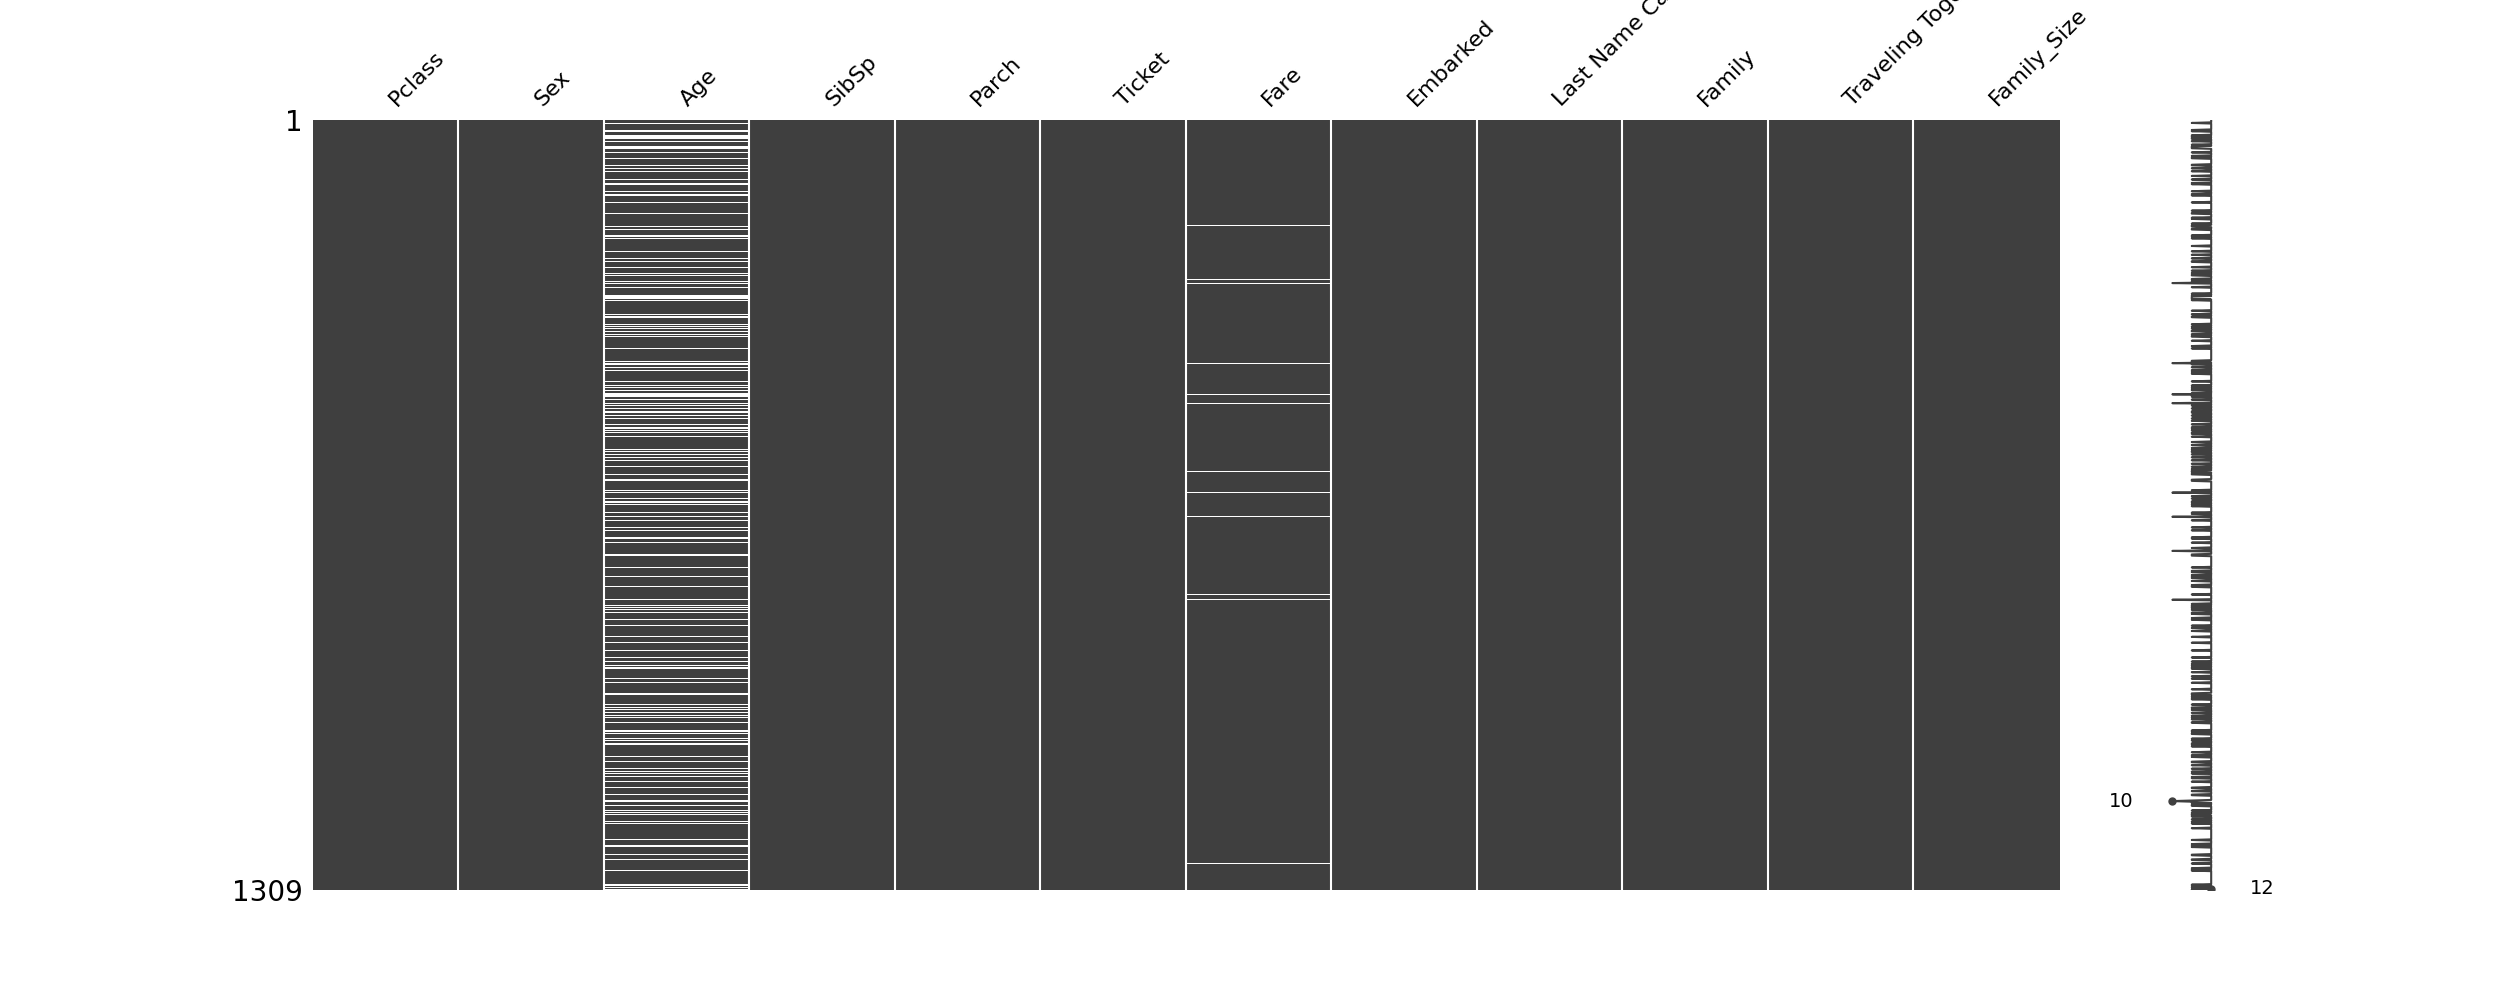

In [ ]:
display(Image(filename="missing_1_train.png"))

Using this table, we can identify various missing values, with the highest number of omissions occurring in the age column and some in the fare column. This information guides us in determining how to handle these gaps. In this scenario, we choose to target the empty samples and replace them with 'np.nan' in these respective sections. Subsequently, we employ a K-nearest neighbors (KNN) imputer to effectively fill in the missing values. We are plotting these figures by reading the saved images generated during the transform_data_train process because we aim to display them in this section.

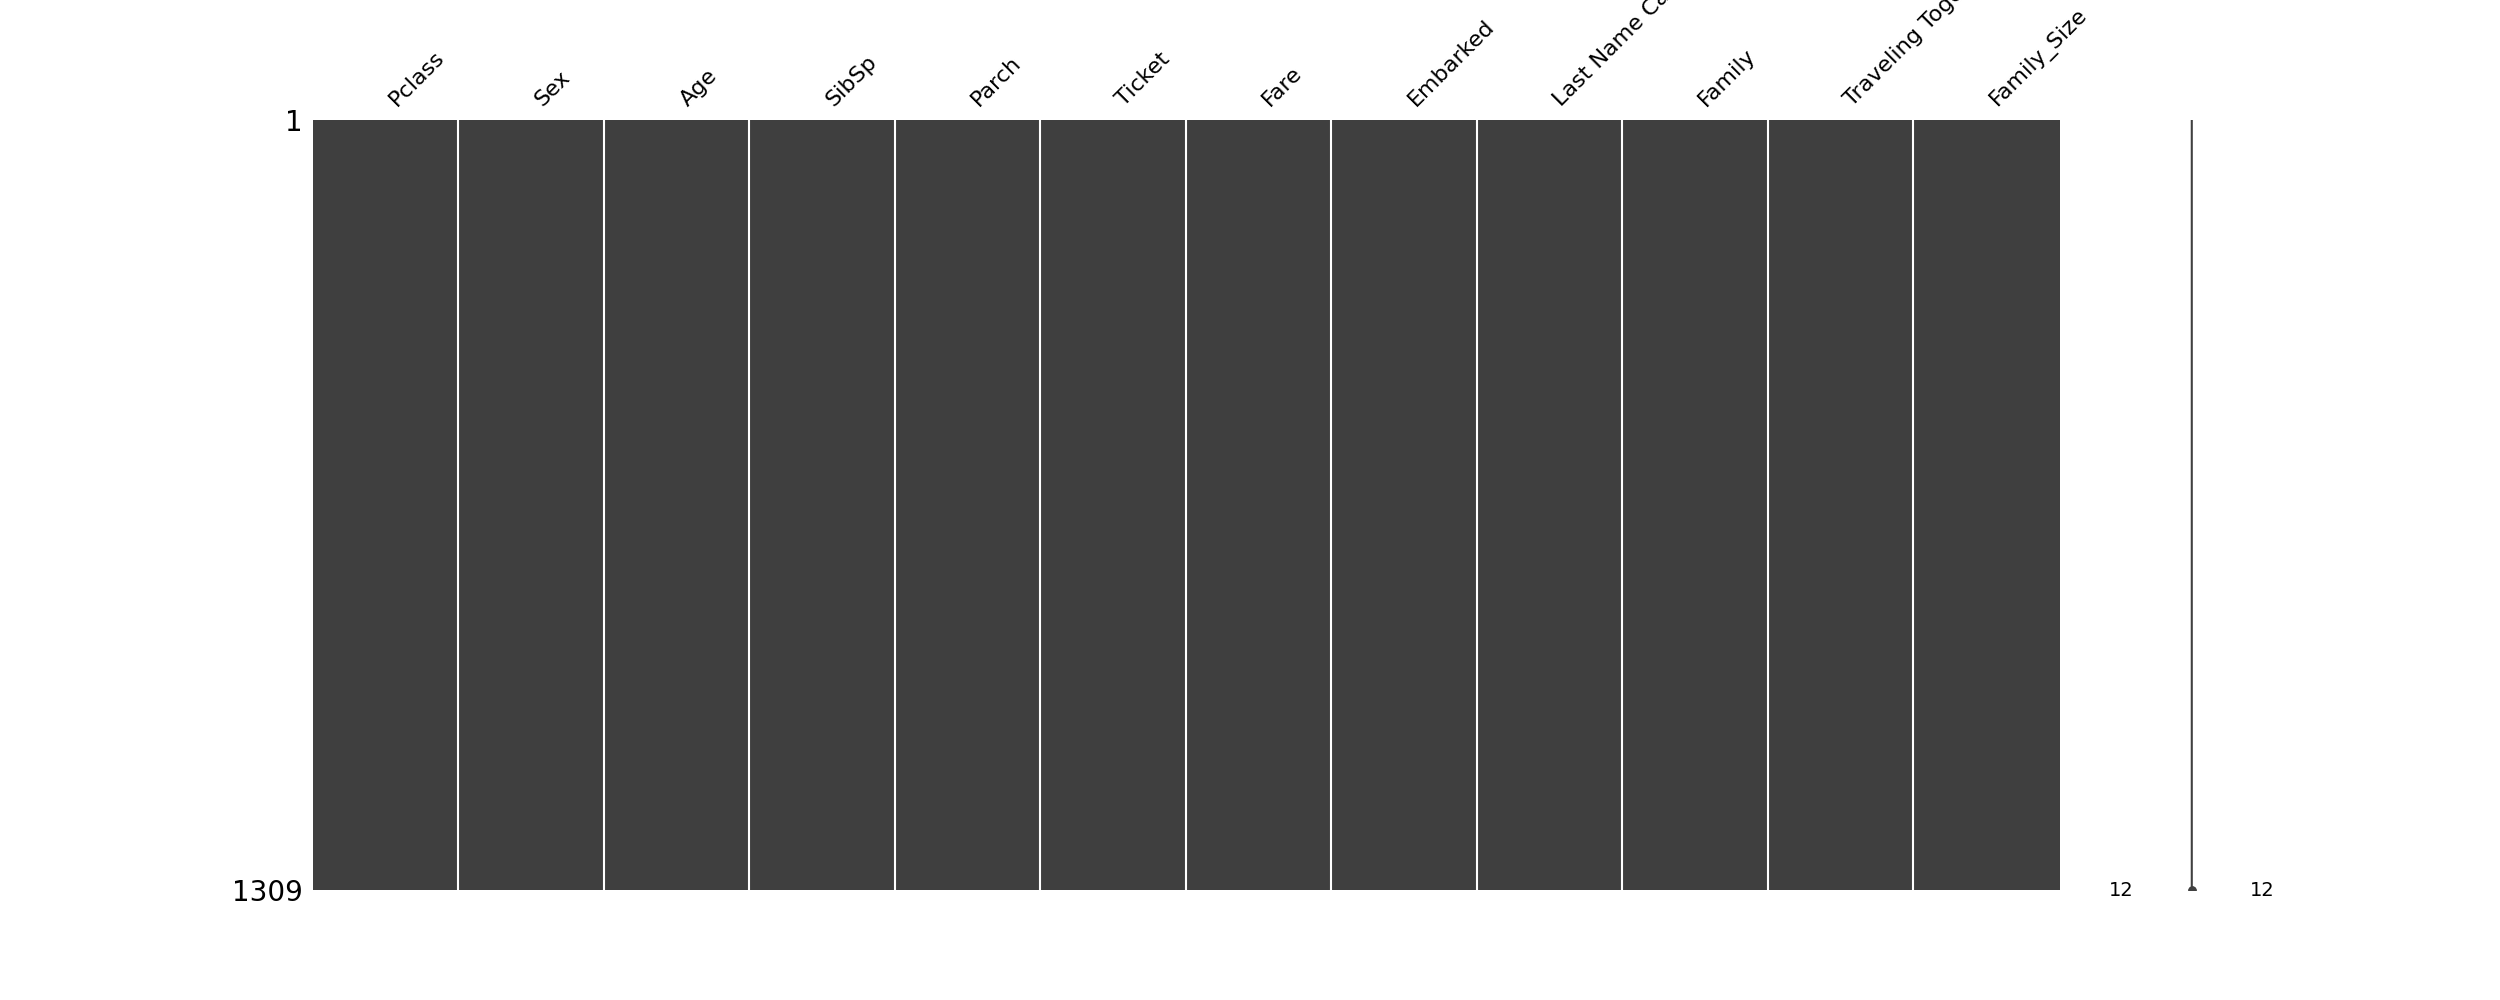

In [ ]:
display(Image(filename="missing_2_train.png"))

Following the application of the KNN imputer to populate the vacant entries, we inspect the results to verify that there are no remaining missing values and to confirm the successful operation of the KNN imputer.

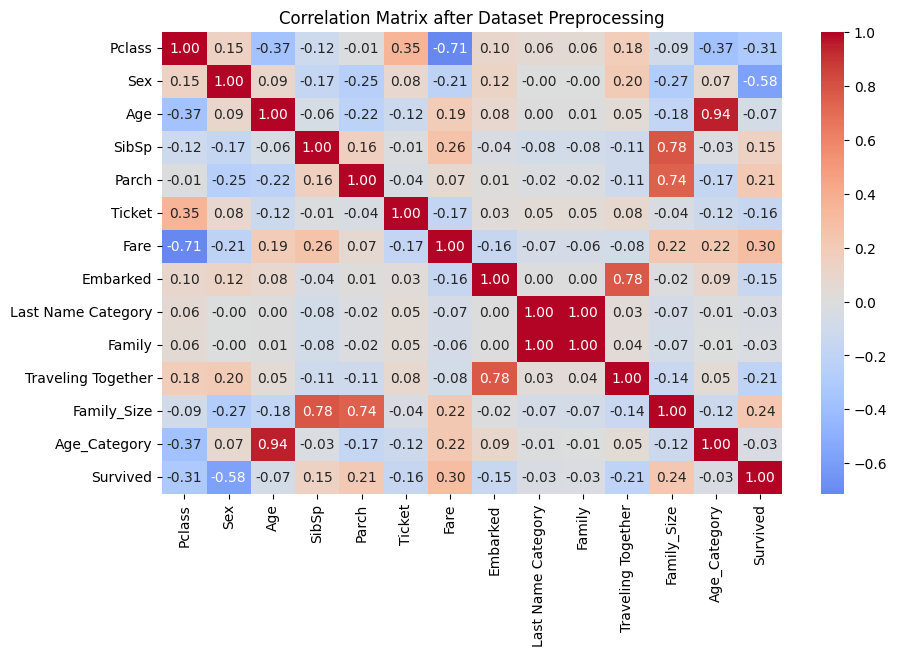

In [ ]:
plt.figure(figsize=(10,6))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0.0, fmt='.2f')
plt.title("Correlation Matrix after Dataset Preprocessing")
plt.show()

The correlation matrix reveals relationships between various features in the dataset. Notable correlations include a negative correlation between "Pclass" ( the passenger class) and "Fare" (the ticket fare), suggesting that higher-class passengers tend to pay more for their tickets. There is also a strong negative correlation between "Sex" (gender) and "Survived," indicating that being male is associated with a lower likelihood of survival. Furthermore, there is a positive correlation between "SibSp" (number of siblings/spouses aboard) and "Family_Size" (family size), indicating that larger families tend to travel together. These correlations provide insights into potential factors affecting passenger survival and other relationships.

After applying the transform_data_train function, the dataset has undergone several transformations and feature engineering steps. Features such as "Last Name Category," "Family," "Traveling Together," and "Age_Category" have been added to provide additional insights into passenger characteristics. Categorical variables like "Sex" and "Embarked" have been encoded for model compatibility. Missing values have been imputed using K-nearest neighbors (KNN) imputation, and outliers have been handled. The dataset is now ready for further analysis and machine learning modeling, with relevant features extracted and preprocessed to facilitate predictions of passenger survival.

In [ ]:
train_df

Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  Embarked  \
1         3    2  22.0      2      1     721   7.2500         3   
2         1    1  38.0      2      1     817  71.2833         1   
3         3    1  26.0      1      1     915   7.9250         3   
4         1    1  35.0      2      1      66  53.1000         3   
5         3    2  35.0      1      1     650   8.0500         3   
..      ...  ...   ...    ...    ...     ...      ...       ...   
887       2    2  27.0      1      1     131  13.0000         3   
888       1    1  19.0      1      1      19  30.0000         3   
889       3    1  33.0      2      3     924  23.4500         3   
890       1    2  26.0      1      1      12  30.0000         1   
891       3    2  32.0      1      1     643   7.7500         2   

     Last Name Category  Family  Traveling Together  Family_Size  \
1                   101     119                 620            2   
2                   183     222                 155            2   
3                   330     405                 783            1   
4                   268     328                 577            2   
5                    16      19                 814            1   
..                  ...     ...                 ...          ...   
887                 536     641                 334            1   
888                 295     358                 526            1   
889                 384     470                 455            4   
890                  70      81                  69            1   
891                 215     261                 244            1   

     Age_Category  Survived  
1               2         0  
2               5         1  
3               3         1  
4               4         1  
5               4         0  
..            ...       ...  
887             3         0  
888             2         1  
889             4         0  
890             3         1  
891             4         0  

[769 rows x 14 columns]

In this block of code, we are generating various plots to visualize the distribution and relationships of specific features in the dataset. These plots serve different purposes depending on whether the features are categorical or numerical. For categorical features like "Age_Category," "Sex," "Pclass," and "Parch," we use distribution plots and cross-tabulation plots to understand how these features may influence survival rates. For numerical features like "Age," "Fare," "SibSp," "Embarked," and "Family_Size," we also create distribution plots and quantile-quantile (QQ) plots to analyze their distributions and identify any deviations from normality. Additionally, scatter plots of features are generated to explore relationships between different attributes. These visualizations aid in gaining insights into the dataset and guide feature selection and engineering for machine learning modeling.

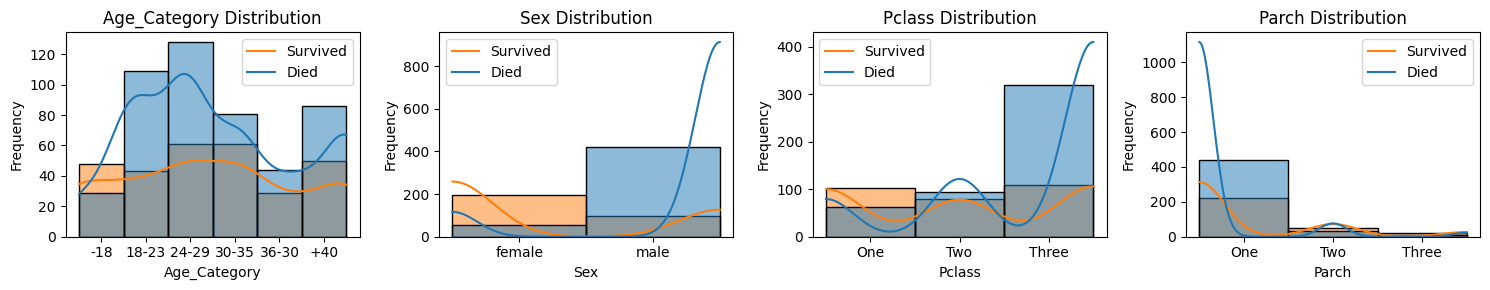

In [ ]:
tickers = [
    ["-18", "18-23", "24-29", "30-35", "36-30", "+40"],
    sex_encoder.classes_,
    ["One", "Two", "Three"],
    ["One", "Two", "Three"]
]
plot_distribution_plots(train_df, "Survived", ["Age_Category", "Sex", "Pclass", "Parch"], tickers)

Cross-tabulation plots, often referred to as contingency tables or crosstabs, are a useful tool in data analysis for exploring the relationships between two categorical variables. They are particularly handy for understanding the distribution of one variable concerning the categories of another variable.

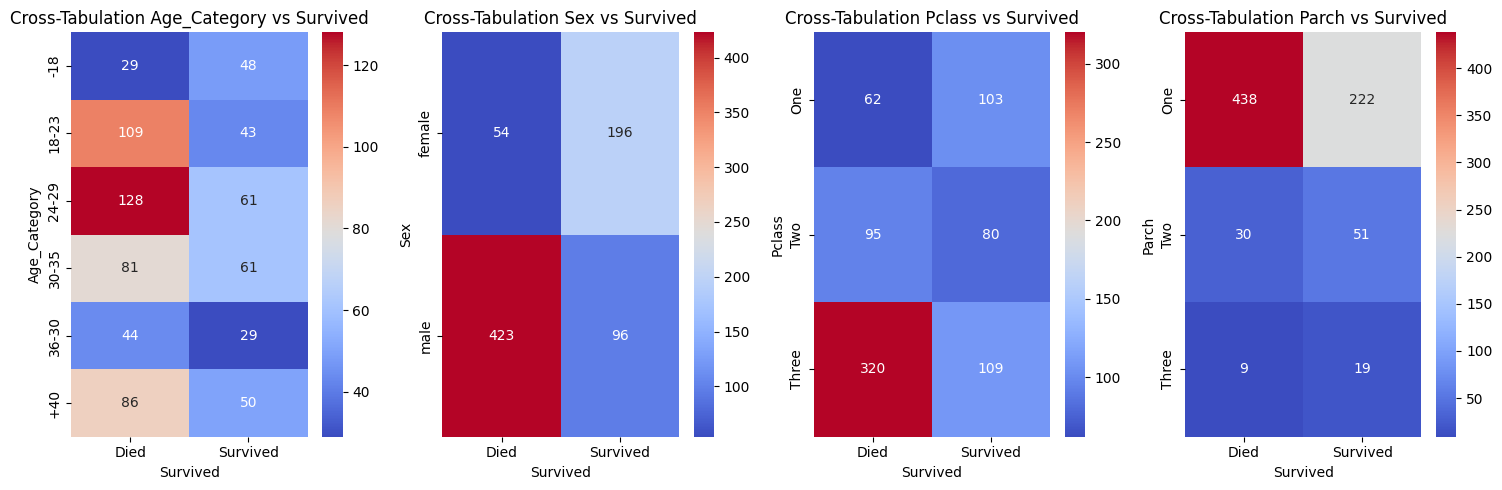

In [ ]:
plot_cross_tabulation(train_df, "Survived", ["Age_Category", "Sex", "Pclass", "Parch"], tickers)

In this table we can observe the same but in a different presentation.

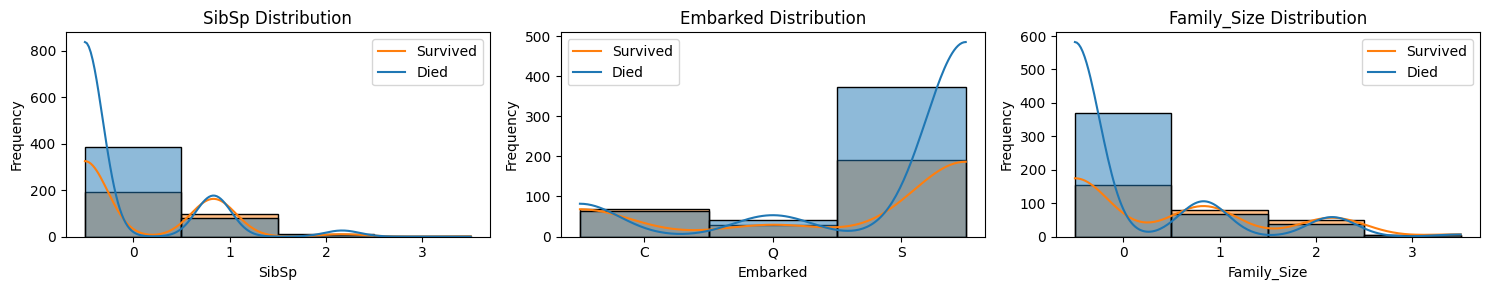

In [ ]:
tickers = [
    ["0", "1", "2", "3"],
    embarked_encoder.classes_[:-1],
    ["0", "1", "2", "3"]
]
plot_distribution_plots(train_df, "Survived", ["SibSp", "Embarked", "Family_Size"], tickers)

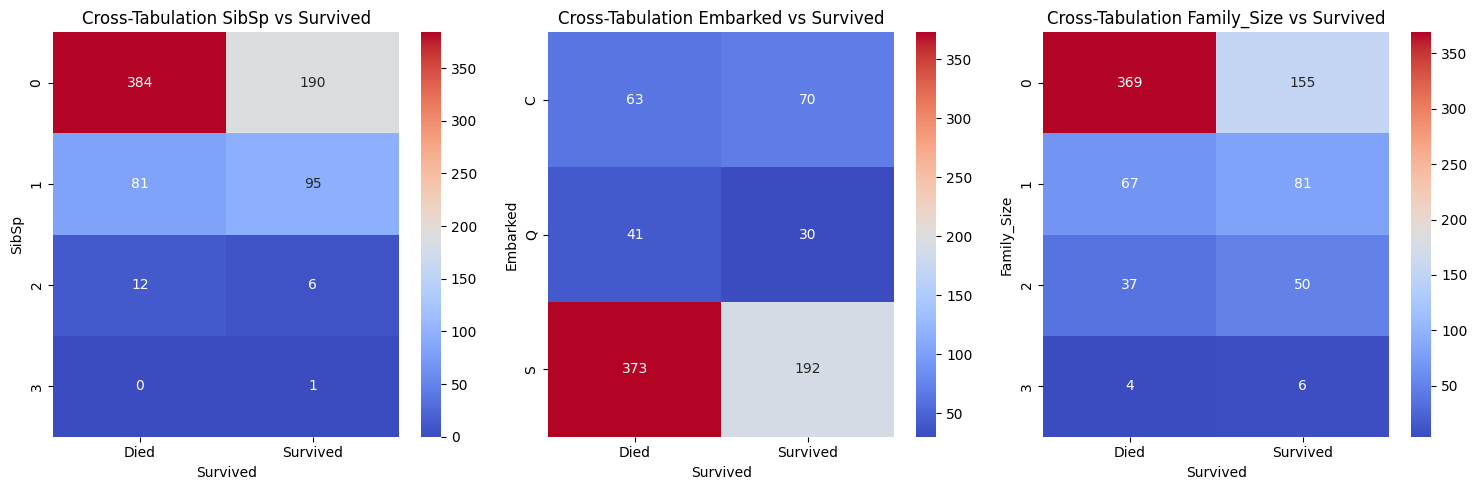

In [ ]:
plot_cross_tabulation(train_df, "Survived", ["SibSp", "Embarked", "Family_Size"], tickers)

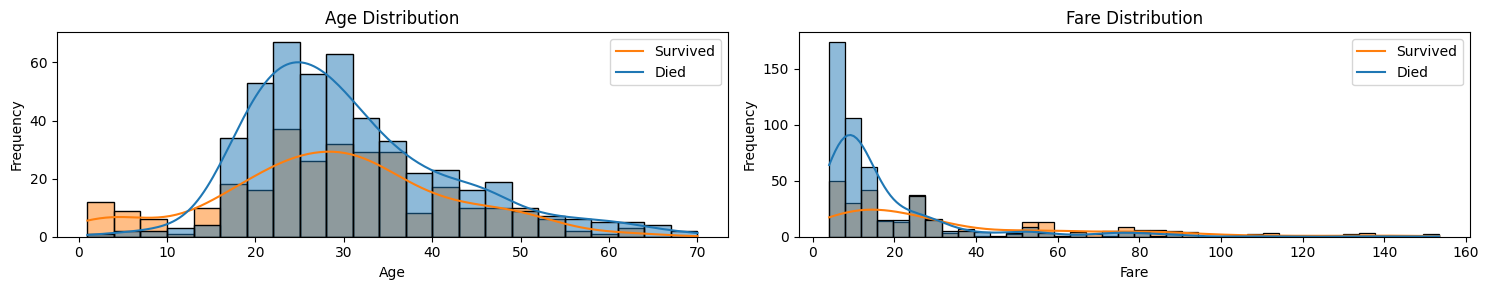

In [ ]:
plot_distribution_plots(train_df, "Survived", ["Age", "Fare"])

QQ plots, or quantile-quantile plots, are used to assess whether a dataset follows a specific theoretical distribution, such as a normal distribution. In this case, we creating QQ plots for the "Age" and "Fare" features. These plots compare the quantiles of the observed data to the quantiles of the theoretical normal distribution. If the points on the QQ plot closely follow a straight line, it suggests that the data follows a normal distribution.

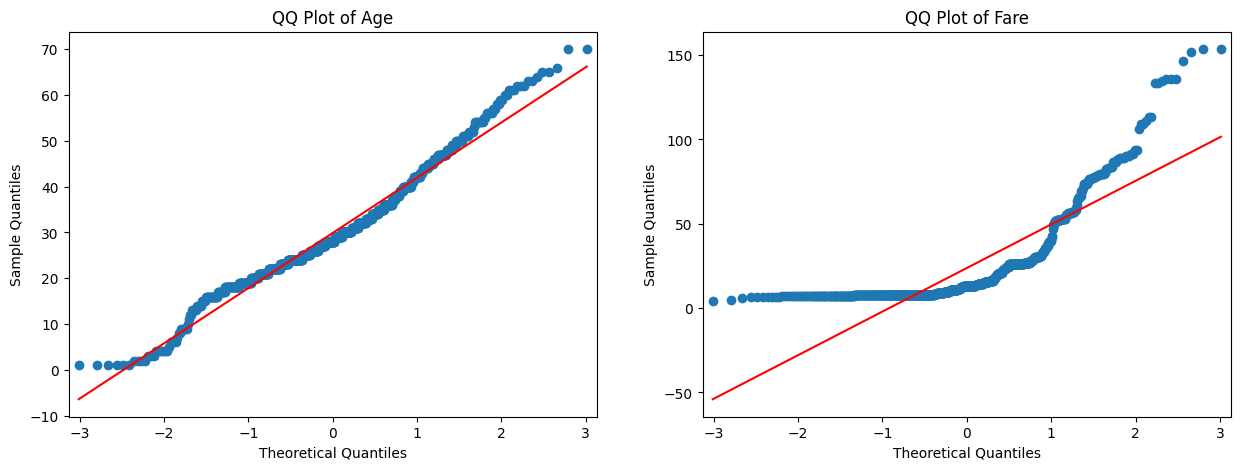

In [ ]:
plot_QQ(train_df, ["Age", "Fare"])

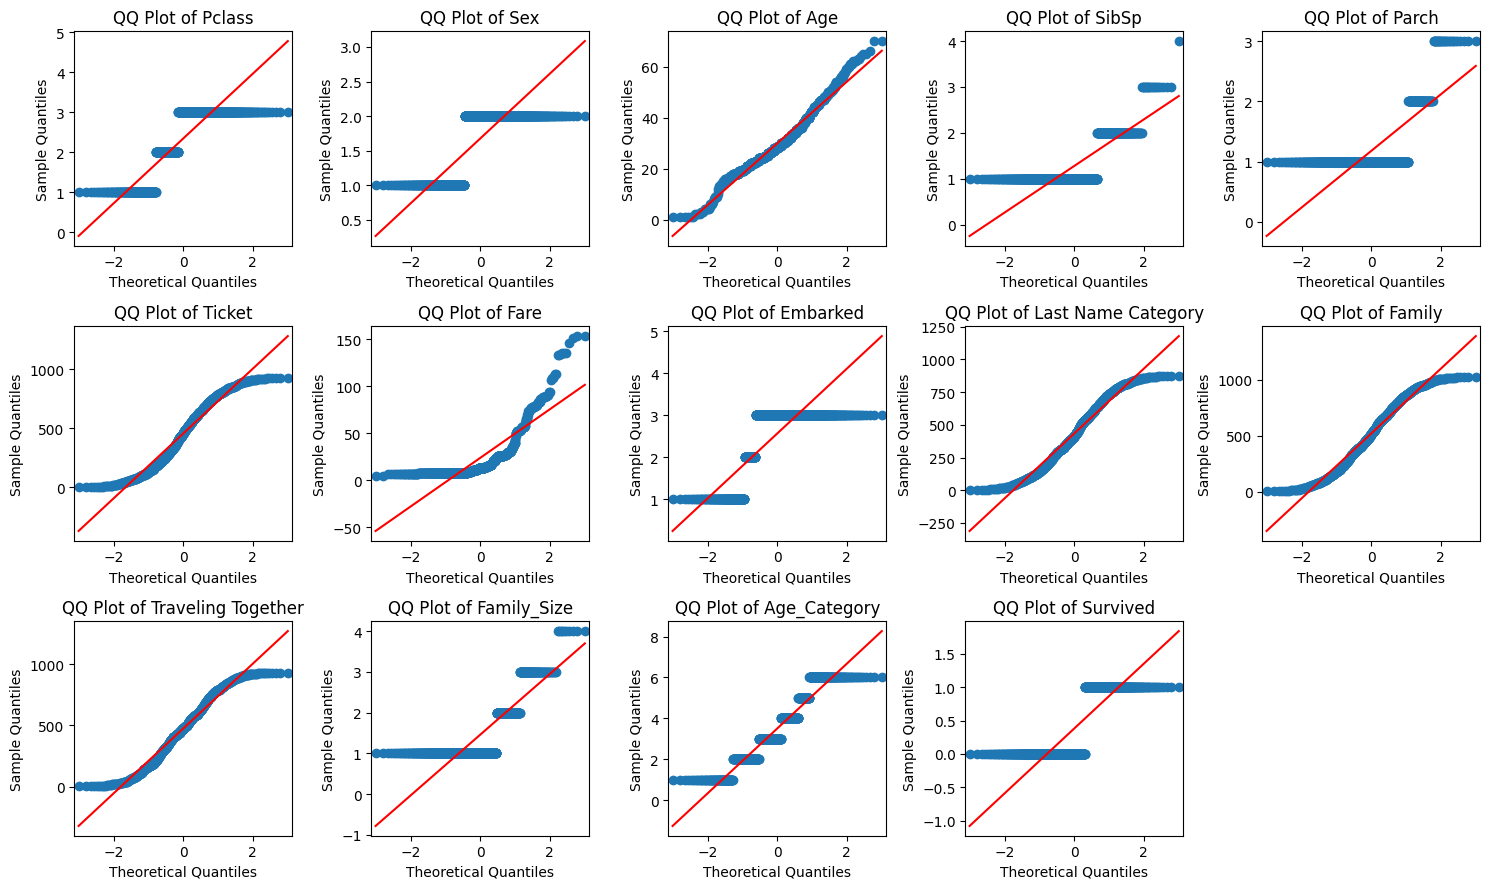

In [ ]:
plot_QQ_features(train_df)

These tables represent the standard deviation in the features.

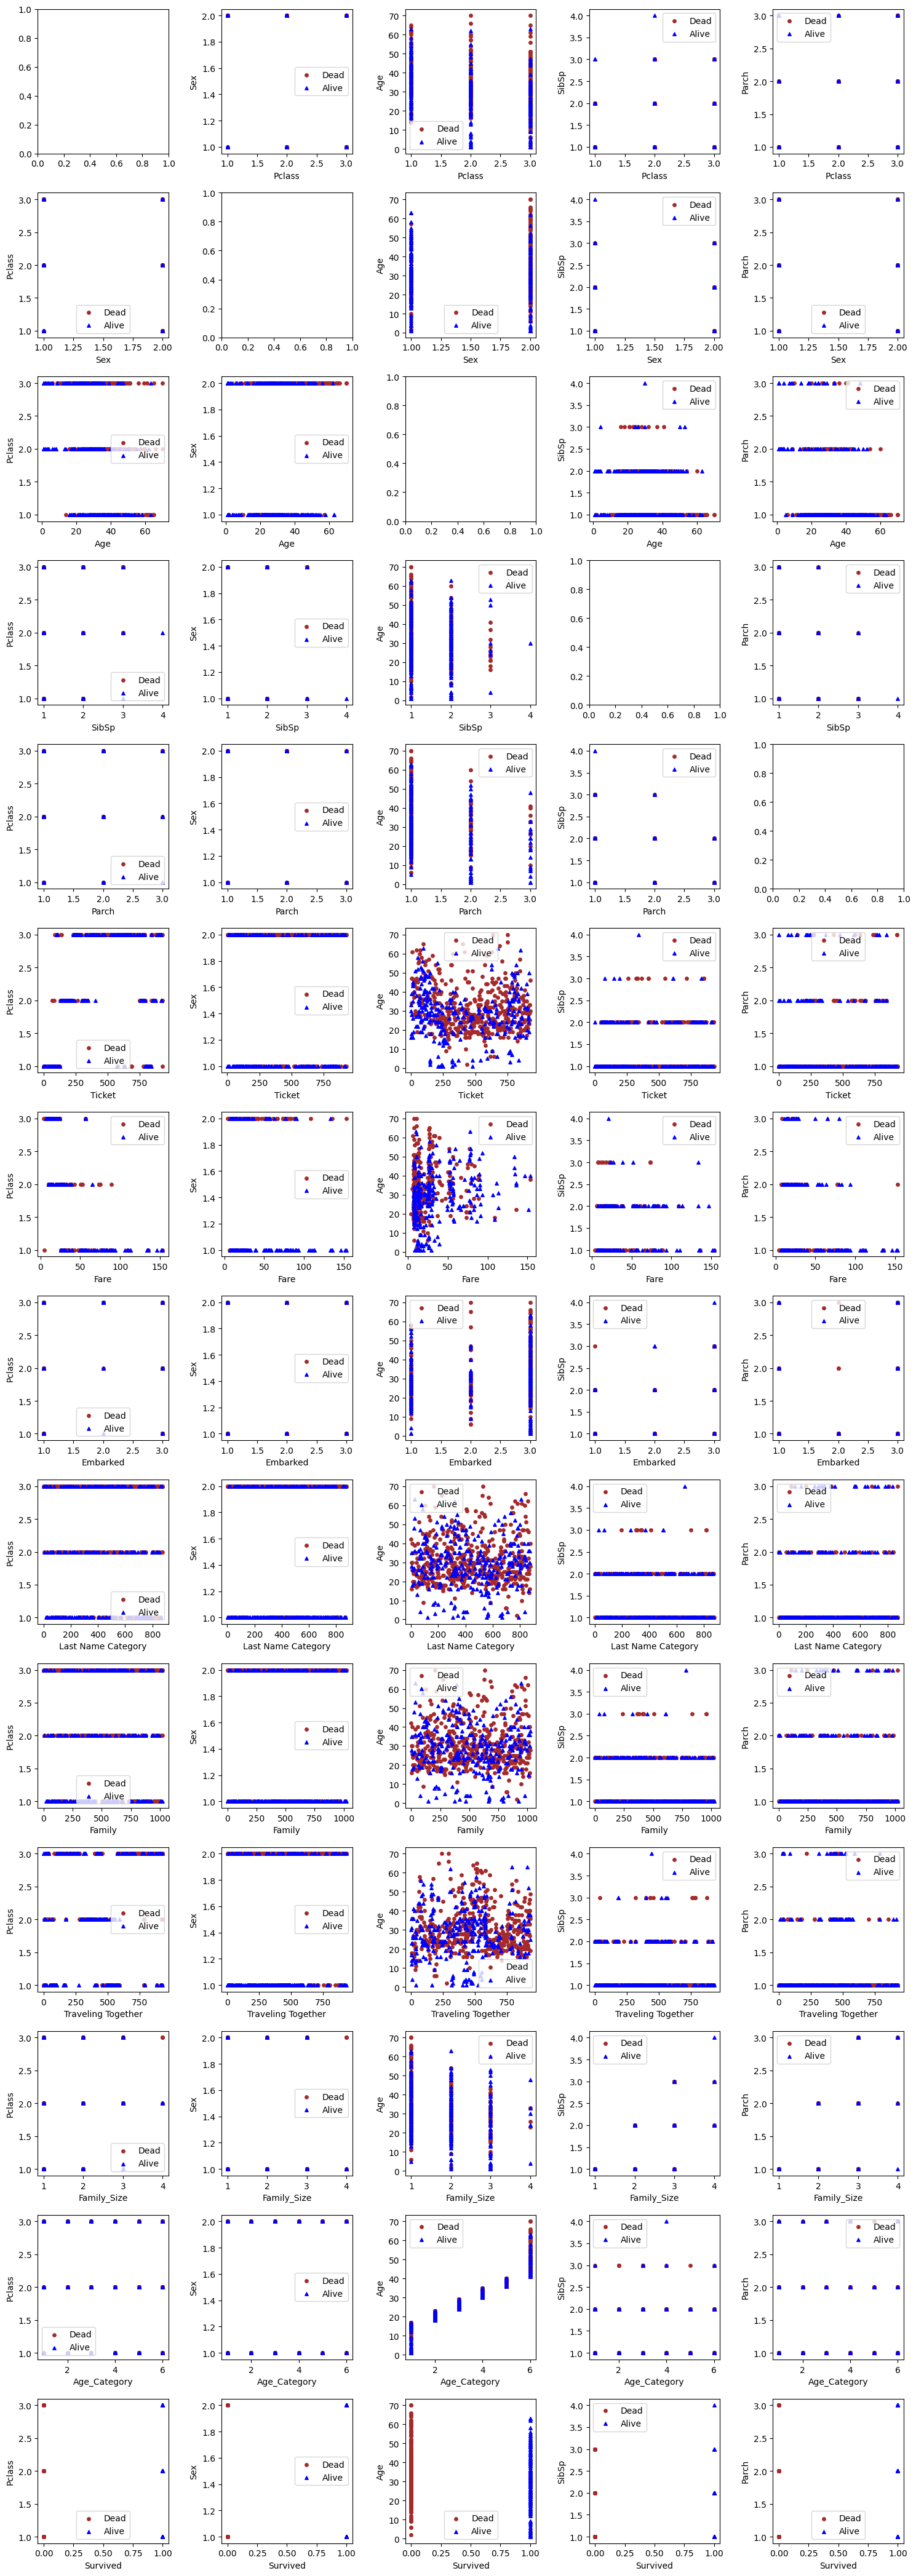

In [ ]:
scatter_plot_features(train_df)

We graph each of the features with the rest of them

### 1.1 Check if data is balanced in classes to be separated

In this code block, we are examining the class distribution within the target variable, "Survived," to assess whether the dataset is balanced or imbalanced in terms of the two classes, "deceased" and "survived." The code calculates the distribution of these classes and then creates a pie chart to visually represent the proportion of each class in the dataset. This visualization helps us understand whether there is an imbalance in the data, as an imbalanced dataset may require handling techniques to ensure model performance is not biased toward the majority class. The autopct function in the pie chart provides the percentage and count of each class, giving a picture of the class distribution.

In [ ]:
y = train_df["Survived"]
X = train_df.drop(["Survived"], axis=1)
X_cols = X.columns
X = X.to_numpy()

In [ ]:
c_distribution = y.value_counts()
c_distribution

0    477
1    292
Name: Survived, dtype: int64

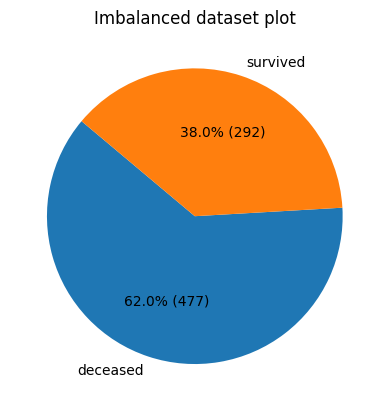

In [ ]:
def my_autopct(pct):
    total = sum(c_distribution)
    absolute = int(pct / 100.0 * total)
    return f'{pct:.1f}% ({absolute})'

fig, ax = plt.subplots()
ax.pie(c_distribution, labels=["deceased", "survived"], autopct=my_autopct, startangle=140)
plt.title("Imbalanced dataset plot")
plt.show()

In [ ]:
print(c_distribution)

0    477
1    292
Name: Survived, dtype: int64


In [ ]:
survived_proba = c_distribution[1]/len(X)
deceased_proba = c_distribution[0]/len(X)

print("Survived probability: %" + str(survived_proba*100))
print("Deceased probability: %" + str(deceased_proba*100))

Survived probability: %37.971391417425224
Deceased probability: %62.028608582574776


In this graph, we can see the difference in the number of persons reported as 'died' and 'alive.' The problem is that having an imbalance in the number of instances between classes can lead to overfitting.

### 1.2 Oversampling

In this code block, we are addressing the issue of class imbalance in the dataset. We are using the Synthetic Minority Over-sampling Technique(SMOTE) from the imbalanced-learn library to oversample the minority class ("survived") in the target variable "Survived.". SMOTE, or Synthetic Minority Over-sampling Technique, is a method used to address class imbalance in datasets. In the context of this dataset, where the number of "deceased" instances significantly outweighs the number of "survived" instances, SMOTE becomes highly relevant. SMOTE works by generating synthetic samples for the minority class, in this case, "survived." It does this by creating new data points that are combinations of existing minority class samples, effectively expanding the dataset and balancing the class distribution. After applying SMOTE, we update the feature matrix X and target variable y to their resampled versions, and then visualize the new class distribution using a pie chart, as done previously. This technique helps ensure that both classes in the dataset are adequately represented, which is crucial for training machine learning models that can make fair predictions for both class outcomes.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
X_res = pd.DataFrame(X_res, columns=X_cols)
X_res["Survived"] = y_res

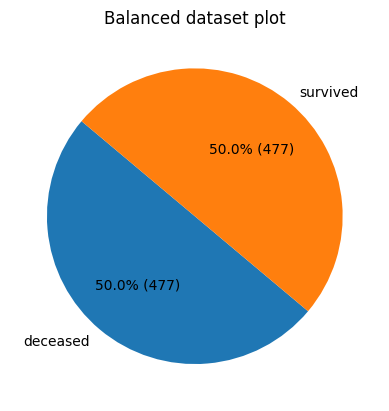

In [ ]:
c_distribution = y_res.value_counts()

def my_autopct(pct):
    total = sum(c_distribution)
    absolute = int(pct / 100.0 * total)
    return f'{pct:.1f}% ({absolute})'

fig, ax = plt.subplots()
ax.pie(c_distribution, labels=["deceased", "survived"], autopct=my_autopct, startangle=140)
plt.title("Balanced dataset plot")
plt.show()

After applying SMOTE to balance the dataset, we observe that the previously underrepresented minority class, "survived," now has an equal number of instances as the majority class, "deceased."

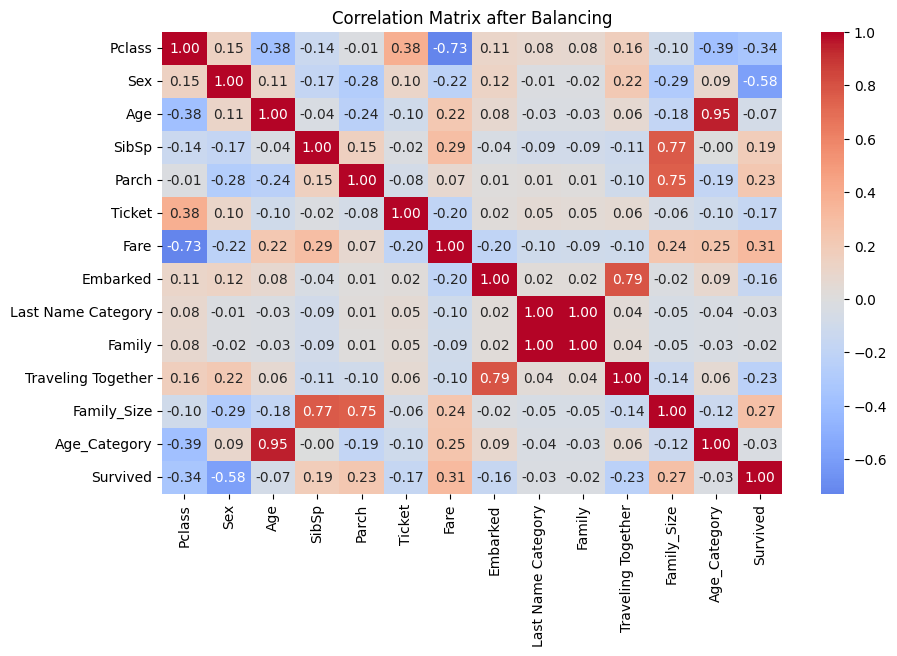

In [ ]:
plt.figure(figsize=(10,6))
correlation_matrix = X_res.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0.0, fmt='.2f')
plt.title("Correlation Matrix after Balancing")
plt.show()

Checking the correlation matrix after balancing the dataset is important because it helps ensure that the relationships between variables are accurately represented in the data, which can impact the performance and interpretability of machine learning models.

After balancing the dataset, the correlation matrix exhibits notable changes in the correlation values between features. The most noticeable shifts include the correlation between "Sex" and "Survived," which became even more negative, indicating a stronger inverse relationship between gender and survival. Additionally, the correlation between "Pclass" and "Survived" has become more negative, emphasizing the influence of passenger class on survival probability. These changes in correlations after balancing the dataset suggest that addressing class imbalance can have a significant impact on the relationships between variables, potentially leading to improved predictive models and more meaningful insights from the data. We can also see that theres a correlation of 1 between "Last Name category" and "Family", this is due because to calculate the family feature, we took into account the "Last Name category".

In [ ]:
correlation_matrix["Survived"][:-1].index

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked',
       'Last Name Category', 'Family', 'Traveling Together', 'Family_Size',
       'Age_Category'],
      dtype='object')

### Multicollinearity and Feature selection

Then here, we are addressing multicollinearity and feature selection. We start by setting a threshold for correlation strength, in this case, 0.05. We then iterate through the correlations between the features and the target variable "Survived." If the absolute correlation is below the threshold, we remove the corresponding feature from both the training and test datasets to reduce redundancy and improve model performance. Finally, we visualize the updated correlation matrix using a heatmap to ensure that highly correlated features have been appropriately removed, contributing to a more effective feature set for machine learning.

In [ ]:
delete_threshold = 0.05

# Initialize list to store pairs of cols
delete_column_pairs = []

survive_corr = correlation_matrix["Survived"][:-1]
for col_name in survive_corr.index:
    if abs(survive_corr[col_name]) < delete_threshold:
        X_res.drop(col_name, axis=1, inplace=True)
        test_df.drop(col_name, axis=1, inplace=True)

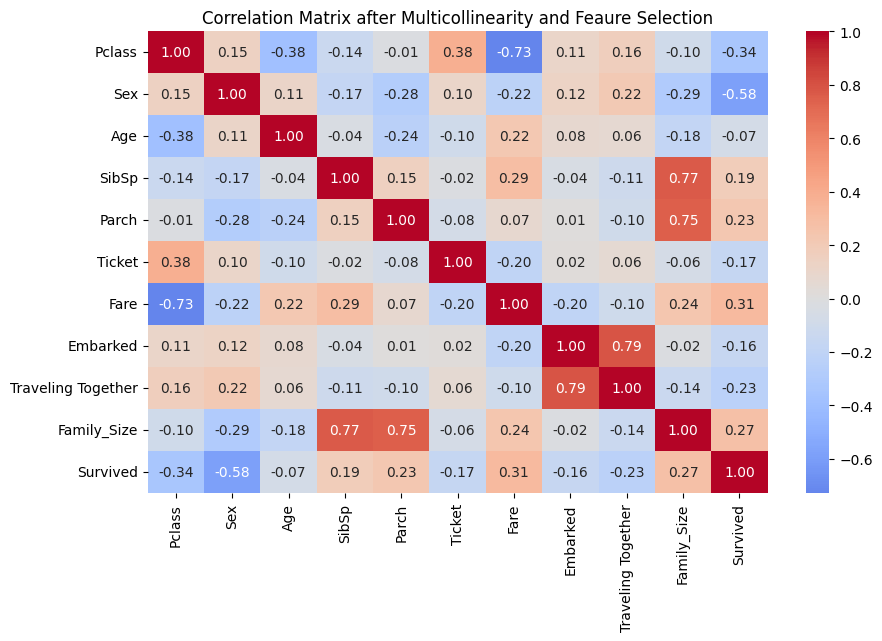

In [ ]:
plt.figure(figsize=(10,6))
correlation_matrix = X_res.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0.0, fmt='.2f')
plt.title("Correlation Matrix after Multicollinearity and Feaure Selection")
plt.show()

After balancing the dataset and addressing multicollinearity and feature selection, several changes have occurred in the correlation matrix. Specifically, several features have been removed due to their low correlation with the target variable "Survived," which was set at a threshold of 0.05. The removed features include "Last Name Category," "Family," "Age_Category," and "Embarked." These features were deemed to have weak correlations with survival and were eliminated to enhance model efficiency and reduce noise. The updated correlation matrix reflects these changes, resulting in a more focused set of features with stronger relationships to the target variable, which can improve the predictive performance of machine learning models.

### Ratio Generation

In the next block, we are identifying pairs of columns within the dataset that have a correlation coefficient greater than or equal to 0.25 or less than or equal to -0.25. These column pairs are stored in the "ratio_column_pairs" list. After identifying these pairs, we create new ratio features for each identified pair. These new features represent the ratio of one column's values to another within the specified column pairs. The newly created features are added to both the training dataset ("X_res") and the testing dataset ("test_df"). This process allows us to capture potentially meaningful relationships between the selected columns that can be beneficial for machine learning models to learn from.

In [ ]:
ratio_threshold = 0.25

# Initialize list to store pairs of cols
ratio_column_pairs = []

# Find pairs of columns with correlations of -0.25 and +0.25
for i in range(len(correlation_matrix.columns) - 1):
    for j in range(i + 1, len(correlation_matrix.columns) - 1):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) >= ratio_threshold:

            ratio_column_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Create new ratio features for the identified pairs
for col1, col2 in ratio_column_pairs:
    new_feature_name = f"{col1}_{col2}_ratio"
    X_res[new_feature_name] = X_res[col1] / X_res[col2]
    test_df[new_feature_name] = test_df[col1] / test_df[col2]

After creating the ratio features from pairs of columns with correlation coefficients greater than or equal to 0.25 or less than or equal to -0.25, we have introduced several new ratio features into the dataset. These features represent the relationships between specific pairs of columns. For example, "Pclass_Ticket_ratio" represents the ratio of "Pclass" to "Ticket," "Sex_Fare_ratio" represents the ratio of "Sex" to "Fare," and so on. These ratio features provide additional information that may capture meaningful patterns or interactions within the data.

In [ ]:
X_res

Pclass      Sex        Age     SibSp     Parch      Ticket       Fare  \
0    3.000000  2.00000  22.000000  2.000000  1.000000  721.000000   7.250000   
1    1.000000  1.00000  38.000000  2.000000  1.000000  817.000000  71.283300   
2    3.000000  1.00000  26.000000  1.000000  1.000000  915.000000   7.925000   
3    1.000000  1.00000  35.000000  2.000000  1.000000   66.000000  53.100000   
4    3.000000  2.00000  35.000000  1.000000  1.000000  650.000000   8.050000   
..        ...      ...        ...       ...       ...         ...        ...   
949  1.156913  2.00000  42.273960  1.000000  1.000000   91.690001  27.936693   
950  2.000000  1.00000  18.253507  1.000000  2.949299  224.036672  12.991127   
951  1.000000  1.00000  57.589133  1.037352  1.037352   51.747032  27.521298   
952  1.000000  1.83598  40.851861  2.000000  1.000000   70.211662  52.463300   
953  3.000000  1.00000  25.743639  1.000000  1.000000  600.080516  11.038478   

     Embarked  Traveling Together  Family_Size  Survived  Pclass_Age_ratio  \
0    3.000000          620.000000     2.000000         0          0.136364   
1    1.000000          155.000000     2.000000         1          0.026316   
2    3.000000          783.000000     1.000000         1          0.115385   
3    3.000000          577.000000     2.000000         1          0.028571   
4    3.000000          814.000000     1.000000         0          0.085714   
..        ...                 ...          ...       ...               ...   
949  1.000000           68.059799     1.000000         1          0.027367   
950  3.000000          374.808515     2.949299         1          0.109568   
951  3.000000          510.465205     1.074703         1          0.017364   
952  3.000000          574.343920     2.000000         1          0.024479   
953  2.695974          296.509498     1.000000         1          0.116534   

     Pclass_Ticket_ratio  Pclass_Fare_ratio  Sex_Parch_ratio  \
0               0.004161           0.413793         2.000000   
1               0.001224           0.014029         1.000000   
2               0.003279           0.378549         1.000000   
3               0.015152           0.018832         1.000000   
4               0.004615           0.372671         2.000000   
..                   ...                ...              ...   
949             0.012618           0.041412         2.000000   
950             0.008927           0.153951         0.339064   
951             0.019325           0.036335         0.963993   
952             0.014243           0.019061         1.835980   
953             0.004999           0.271777         1.000000   

     Sex_Family_Size_ratio  SibSp_Fare_ratio  SibSp_Family_Size_ratio  \
0                 1.000000          0.275862                 1.000000   
1                 0.500000          0.028057                 1.000000   
2                 1.000000          0.126183                 1.000000   
3                 0.500000          0.037665                 1.000000   
4                 2.000000          0.124224                 1.000000   
..                     ...               ...                      ...   
949               2.000000          0.035795                 1.000000   
950               0.339064          0.076976                 0.339064   
951               0.930489          0.037693                 0.965245   
952               0.917990          0.038122                 1.000000   
953               1.000000          0.090592                 1.000000   

     Parch_Family_Size_ratio  Embarked_Traveling Together_ratio  
0                   0.500000                           0.004839  
1                   0.500000                           0.006452  
2                   1.000000                           0.003831  
3                   0.500000                           0.005199  
4                   1.000000                           0.003686  
..                       ...                                ...  
9

Ploting again the distribution plots, cross-tabulation plots, QQ plots, and scatter plots after balancing the classes, oversampling, addressing multicollinearity, and feature selection is necessary to assess the impact of these preprocessing steps on the data and its relationships.Therefore, we should expect these plots to reveal a more balanced and informative representation of the data, with clearer distinctions between different classes and improved model interpretability and generalization.

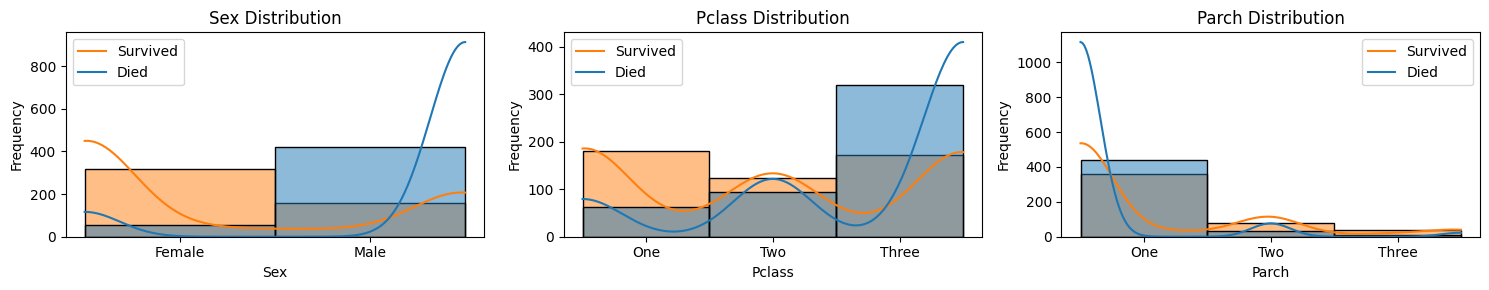

In [ ]:
tickers = [
    ["Female", "Male"],
    ["One", "Two", "Three"],
    ["One", "Two", "Three"]
]
plot_distribution_plots(X_res, "Survived", ["Sex", "Pclass", "Parch"], tickers)

With these distribution graphs after filling in the missing data and balancing the data set, we can see the relationship of how much they survived depending on each feature.

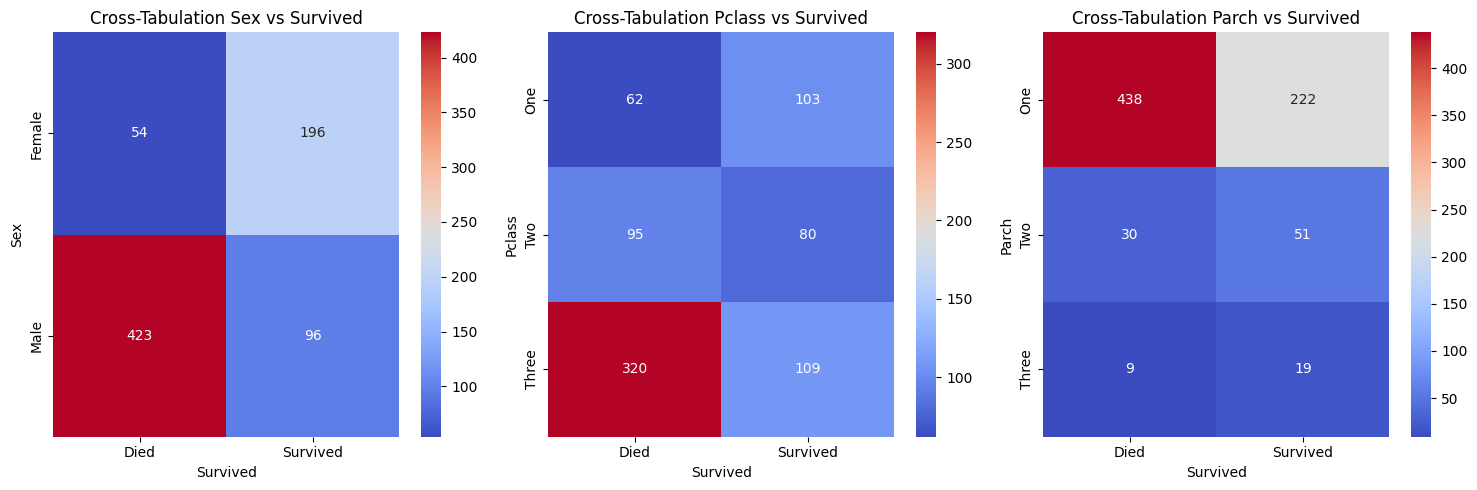

In [ ]:
plot_cross_tabulation(X_res, "Survived", ["Sex", "Pclass", "Parch"], tickers)

On the cross tabulation graphs we are seeing the distribution of each features, in this case we are getting the distribution of the with the sex, the Pclass and the Parch of the passengers who died and survived

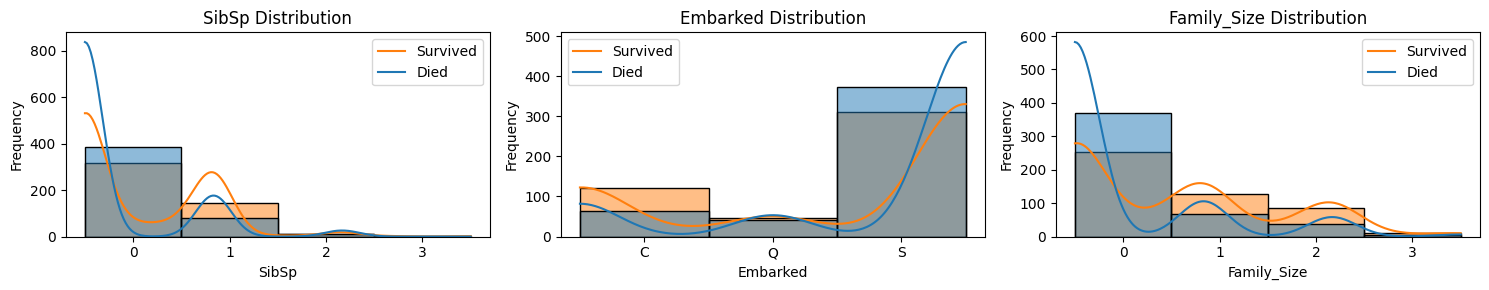

In [ ]:
tickers = [
    ["0", "1", "2", "3"],
    embarked_encoder.classes_[:-1],
    ["0", "1", "2", "3"]
]
plot_distribution_plots(X_res, "Survived", ["SibSp", "Embarked", "Family_Size"], tickers)

On this distribution plot, we can se how much those the one who Died surpasses in some of the features to the ones that survive, this is similar to the las graph but with a visual help instead of numbers

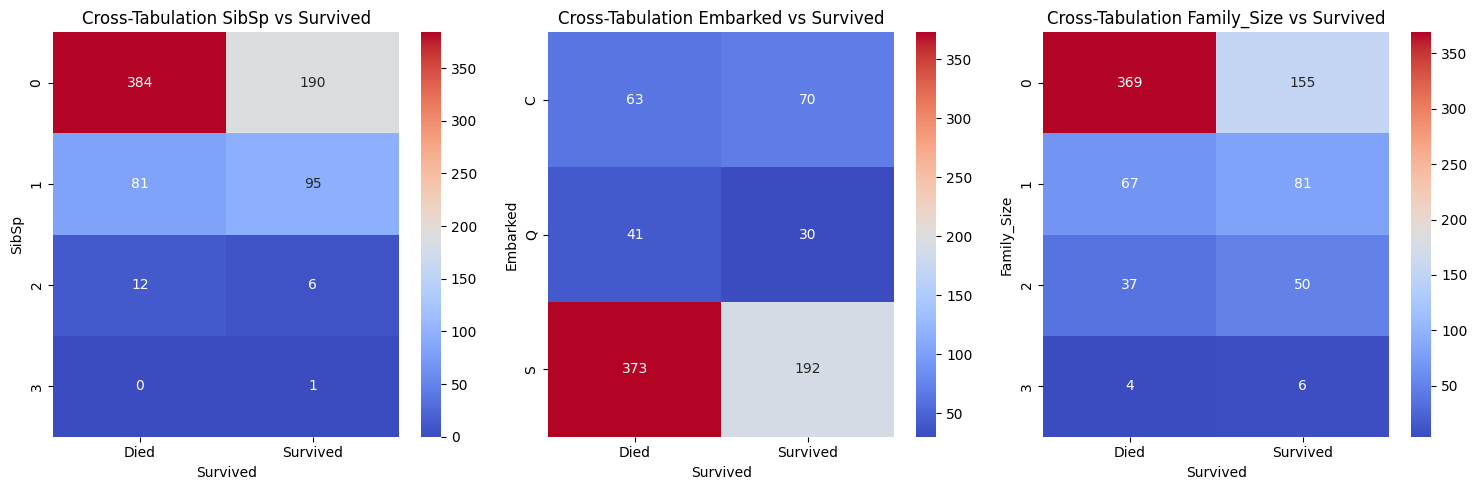

In [ ]:
plot_cross_tabulation(X_res, "Survived", ["SibSp", "Embarked", "Family_Size"], tickers)

These cross-validation tables are used to examine the correlation between the number of survivors and specific features such as SibSp (number of siblings/spouses aboard), embarked (port of embarkation), and family size. By analyzing these tables, we can gain insights into how these factors relate to the likelihood of survival among passengers.

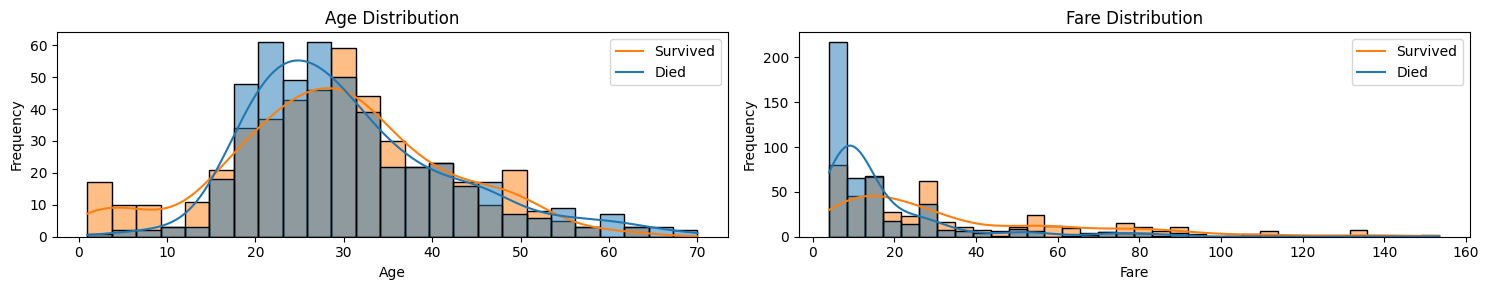

In [ ]:
plot_distribution_plots(X_res, "Survived", ["Age", "Fare"])

In this graph, the distribution of the data now with the age and the fare of each passengers, this help us to understand that does passengers that were younger, on a range of 20 years to 35 were more likely to survive, from the other hand con the Fare distribution those who paid more where the ones who

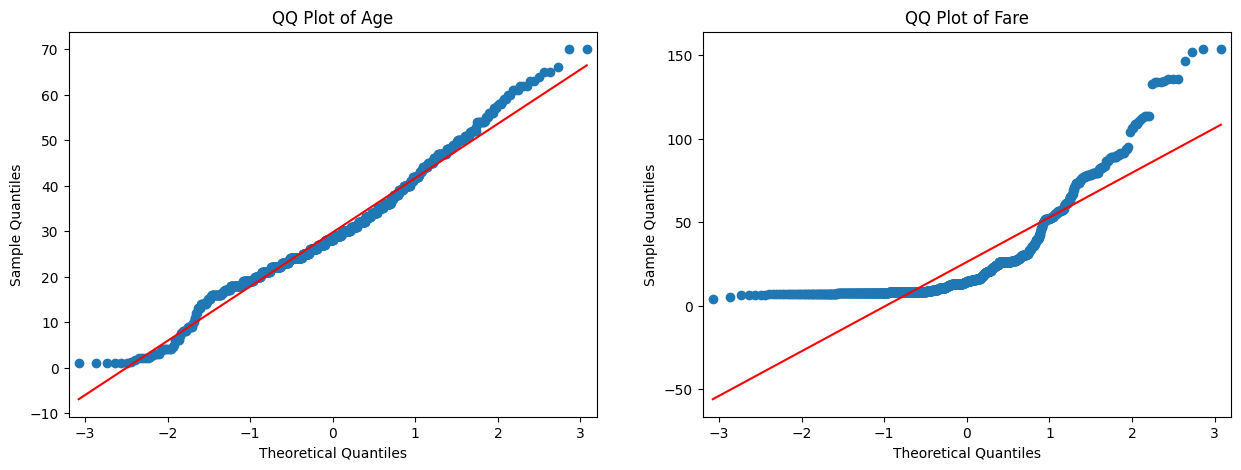

In [ ]:
plot_QQ(X_res, ["Age", "Fare"])

We are examining how the Age and Fare data points diverge from the expected pattern of a standard distribution. When data points deviate significantly from the diagonal line in the QQ plot, it suggests that the dataset may not adhere to the expected distribution, indicating potential outliers or deviations from normality.

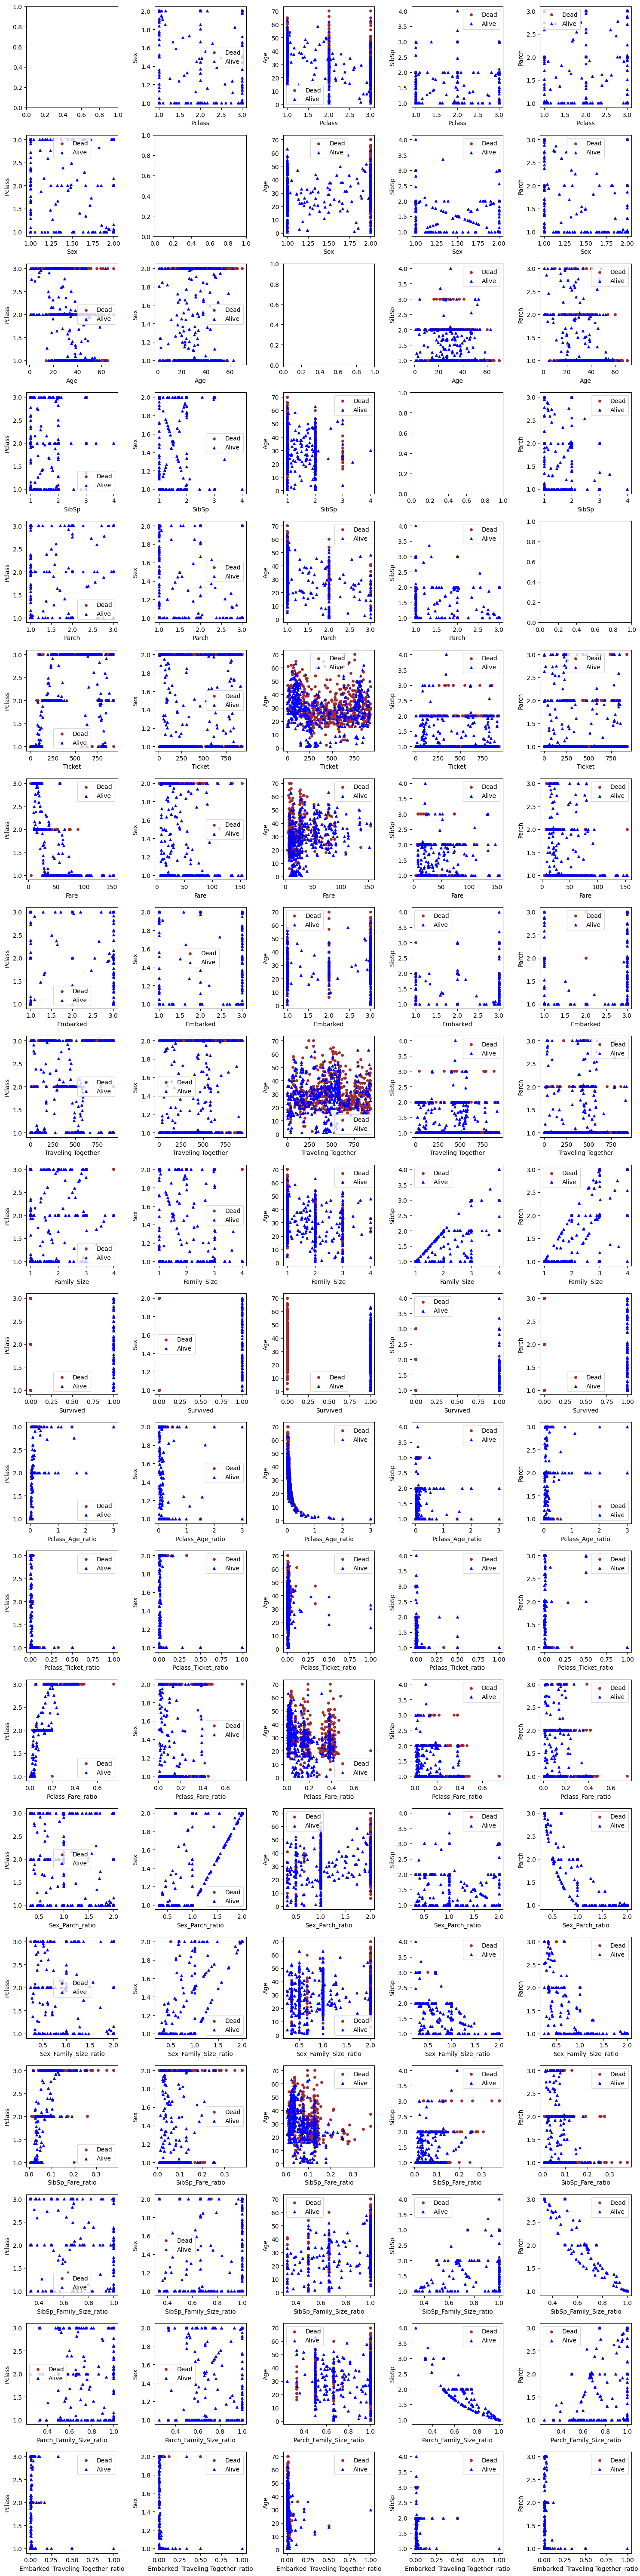

In [ ]:
scatter_plot_features(X_res)

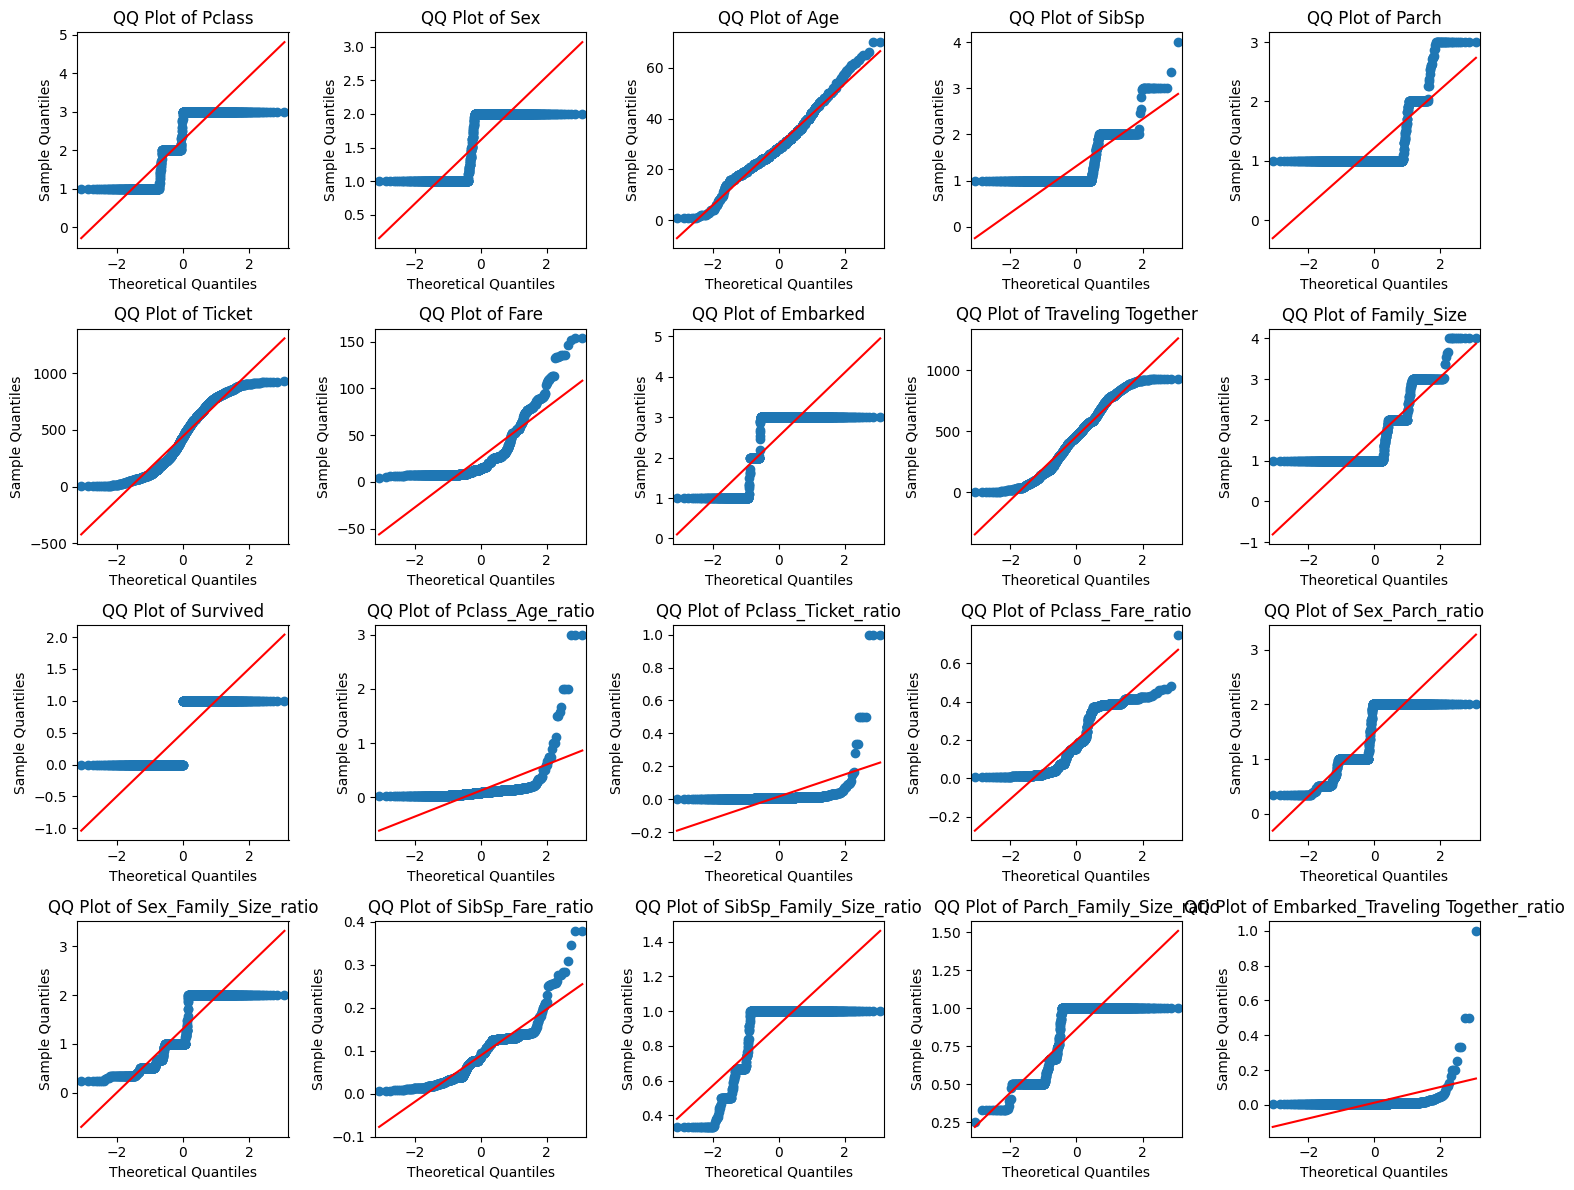

In [ ]:
plot_QQ_features(X_res)

### Scaling or Normalizing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In this section, we are preparing our dataset for machine learning by encoding categorical features and applying scaling or normalization to numerical features based on their characteristics.

**Categorical Feature Encoding:**
We start by encoding categorical features to numerical values to make them compatible with machine learning algorithms. Specifically:

We create binary columns 'Male' and 'Female' based on the 'Sex' feature, effectively converting it into a one-hot encoded format.
Similarly, we create binary columns 'Embarked_Cherbourg', 'Embarked_Queenstown', and 'Embarked_Southampton' based on the 'Embarked' feature, applying one-hot encoding.
After encoding the categorical features, we drop the original 'Sex' and 'Embarked' columns to avoid redundancy.

**Scaling and Normalization of Numerical Features:**
We then address the scaling or normalization of numerical features based on their characteristics:

For continuous numerical features 'Age' and 'Fare,' we choose to normalize them using Min-Max scaling. This transformation scales the data to a specific range, typically between 0 and 1, preserving the original distribution.
Discrete numerical features like 'Pclass,' 'SibSp,' 'Parch,' 'Last Name Category,' 'Family,' and various ratio features are left unchanged because they are already on a discrete scale, and no further scaling or normalization is necessary.

In [ ]:
def encode_data(df, train = True):
    df['Male'] = (df['Sex'] == 2).astype(int)
    df['Female'] = (df['Sex'] == 1).astype(int)

    df["Embarked_Cherbourg"] = (df['Embarked'] == 1).astype(int)
    df["Embarked_Queenstown"] = (df['Embarked'] == 2).astype(int)
    df["Embarked_Southampton"] = (df['Embarked'] == 3).astype(int)

    df = df.drop(["Sex", "Embarked"], axis=1)
    if train:
        return df.drop(["Survived"], axis=1), df["Survived"]
    else:
        return df

In [ ]:
X_train, y_train = encode_data(X_res)
X_test = encode_data(test_df, train=False)

In [ ]:
scaler = MinMaxScaler().fit(X_train[['Age', 'Fare']])
X_train[['Age', 'Fare']] = scaler.transform(X_res[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

In [ ]:
X_train

Pclass       Age     SibSp     Parch      Ticket      Fare  \
0    3.000000  0.304348  2.000000  1.000000  721.000000  0.021663   
1    1.000000  0.536232  2.000000  1.000000  817.000000  0.450122   
2    3.000000  0.362319  1.000000  1.000000  915.000000  0.026179   
3    1.000000  0.492754  2.000000  1.000000   66.000000  0.328454   
4    3.000000  0.492754  1.000000  1.000000  650.000000  0.027016   
..        ...       ...       ...       ...         ...       ...   
949  1.156913  0.598173  1.000000  1.000000   91.690001  0.160082   
950  2.000000  0.250051  1.000000  2.949299  224.036672  0.060078   
951  1.000000  0.820132  1.037352  1.037352   51.747032  0.157302   
952  1.000000  0.577563  2.000000  1.000000   70.211662  0.324194   
953  3.000000  0.358603  1.000000  1.000000  600.080516  0.047012   

     Traveling Together  Family_Size  Pclass_Age_ratio  Pclass_Ticket_ratio  \
0            620.000000     2.000000          0.136364             0.004161   
1            155.000000     2.000000          0.026316             0.001224   
2            783.000000     1.000000          0.115385             0.003279   
3            577.000000     2.000000          0.028571             0.015152   
4            814.000000     1.000000          0.085714             0.004615   
..                  ...          ...               ...                  ...   
949           68.059799     1.000000          0.027367             0.012618   
950          374.808515     2.949299          0.109568             0.008927   
951          510.465205     1.074703          0.017364             0.019325   
952          574.343920     2.000000          0.024479             0.014243   
953          296.509498     1.000000          0.116534             0.004999   

     ...  Sex_Family_Size_ratio  SibSp_Fare_ratio  SibSp_Family_Size_ratio  \
0    ...               1.000000          0.275862                 1.000000   
1    ...               0.500000          0.028057                 1.000000   
2    ...               1.000000          0.126183                 1.000000   
3    ...               0.500000          0.037665                 1.000000   
4    ...               2.000000          0.124224                 1.000000   
..   ...                    ...               ...                      ...   
949  ...               2.000000          0.035795                 1.000000   
950  ...               0.339064          0.076976                 0.339064   
951  ...               0.930489          0.037693                 0.965245   
952  ...               0.917990          0.038122                 1.000000   
953  ...               1.000000          0.090592                 1.000000   

     Parch_Family_Size_ratio  Embarked_Traveling Together_ratio  Male  Female  \
0                   0.500000                           0.004839     1       0   
1                   0.500000                           0.006452     0       1   
2                   1.000000                           0.003831     0       1   
3                   0.500000                           0.005199     0       1   
4                   1.000000                           0.003686     1       0   
..                       ...                                ...   ...     ...   
949                 1.000000                           0.014693     1       0   
950                 1.000000                           0.008004     0       1   
951                 0.965245                           0.005877     0       1   
952                 0.500000                           0.005223     0       0   
953                 1.000000                           0.009092     0       1   

     Embarked_Cherbourg  Embarked_Queenstown  Embarked_Southampton  
0                     0                    0                     1  
1                     1                    0                     0  
2                     0                    0                     1  
3                     0                    

In [ ]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
949    1
950    1
951    1
952    1
953    1
Name: Survived, Length: 954, dtype: int64

In [ ]:
X_test

Pclass       Age  SibSp  Parch  Ticket      Fare  Traveling Together  \
892      3.0  0.478261    1.0    1.0   377.0  0.025538               262.0   
893      3.0  0.666667    2.0    1.0   583.0  0.019990               596.0   
894      2.0  0.884058    1.0    1.0   185.0  0.037973               277.0   
895      3.0  0.376812    1.0    1.0   367.0  0.031114               879.0   
896      3.0  0.304348    2.0    2.0   339.0  0.055370               325.0   
...      ...       ...    ...    ...     ...       ...                 ...   
1305     3.0  0.275362    1.0    1.0   712.0  0.027016               826.0   
1306     1.0  0.550725    1.0    1.0   835.0  0.701823                 2.0   
1307     3.0  0.536232    1.0    1.0   873.0  0.021663               628.0   
1308     3.0  0.420290    1.0    1.0   580.0  0.027016               806.0   
1309     3.0  0.246377    2.0    2.0   263.0  0.122755                41.0   

      Family_Size  Pclass_Age_ratio  Pclass_Ticket_ratio  ...  \
892           1.0          0.088235             0.007958  ...   
893           2.0          0.063830             0.005146  ...   
894           1.0          0.032258             0.010811  ...   
895           1.0          0.111111             0.008174  ...   
896           3.0          0.136364             0.008850  ...   
...           ...               ...                  ...  ...   
1305          1.0          0.150000             0.004213  ...   
1306          1.0          0.025641             0.001198  ...   
1307          1.0          0.078947             0.003436  ...   
1308          1.0          0.100000             0.005172  ...   
1309          3.0          0.166667             0.011407  ...   

      Sex_Family_Size_ratio  SibSp_Fare_ratio  SibSp_Family_Size_ratio  \
892                2.000000          0.127727                 1.000000   
893                0.500000          0.285714                 1.000000   
894                2.000000          0.103226                 1.000000   
895                2.000000          0.115440                 1.000000   
896                0.333333          0.162767                 0.666667   
...                     ...               ...                      ...   
1305               2.000000          0.124224                 1.000000   
1306               1.000000          0.009183                 1.000000   
1307               2.000000          0.137931                 1.000000   
1308               2.000000          0.124224                 1.000000   
1309               0.666667          0.089452                 0.666667   

      Parch_Family_Size_ratio  Embarked_Traveling Together_ratio  Male  \
892                  1.000000                           0.007634     1   
893                  0.500000                           0.005034     0   
894                  1.000000                           0.007220     1   
895                  1.000000                           0.003413     1   
896                  0.666667                           0.009231     0   
...                       ...                                ...   ...   
1305                 1.000000                           0.003632     1   
1306                 1.000000                           0.500000     0   
1307                 1.000000                           0.004777     1   
1308                 1.000000                           0.003722     1   
1309                 0.666667                           0.024390     1   

      Female  Embarked_Cherbourg  Embarked_Queenstown  Embarked_Southampton  
892        0                   0                    1                     0  
893        1                   0                    0                     1  
894        0                   0                    1                     0  
895        0                   0                    0                     1  
896        1                   0                    0                     1  
...      ...                 ...          

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_kg_train, y_kg_train, test_size=0.2, random_state=42)

## Dimension Analysis

Applying dimensionality analysis is crucial in our case as it can reveal the impact and significance of each feature on the predictive model's performance. By identifying and retaining the most informative features while eliminating redundant or irrelevant ones, dimensionality analysis helps improve model accuracy, reduce computational complexity, and prevent overfitting. It enables us to streamline our dataset, making it more efficient for modeling while preserving the essential information necessary for making accurate predictions, ultimately enhancing the overall effectiveness of our machine learning approach.

### PCA

Principal Component Analysis (PCA) is a dimensionality reduction technique that works by transforming the original features into a new set of uncorrelated variables called principal components. These principal components capture the maximum variance in the data while reducing its dimensionality. In our dataset, PCA can be applied to identify linear relationships and correlations between features, potentially reducing multicollinearity. By projecting the data onto a lower-dimensional subspace defined by the principal components, PCA can simplify our dataset while preserving the most critical information. This can be particularly useful for improving the efficiency and interpretability of our machine learning model, especially when dealing with a large number of features.

In [ ]:
X_train

Pclass       Age     SibSp     Parch      Ticket      Fare  \
0    3.000000  0.304348  2.000000  1.000000  721.000000  0.021663   
1    1.000000  0.536232  2.000000  1.000000  817.000000  0.450122   
2    3.000000  0.362319  1.000000  1.000000  915.000000  0.026179   
3    1.000000  0.492754  2.000000  1.000000   66.000000  0.328454   
4    3.000000  0.492754  1.000000  1.000000  650.000000  0.027016   
..        ...       ...       ...       ...         ...       ...   
949  1.156913  0.598173  1.000000  1.000000   91.690001  0.160082   
950  2.000000  0.250051  1.000000  2.949299  224.036672  0.060078   
951  1.000000  0.820132  1.037352  1.037352   51.747032  0.157302   
952  1.000000  0.577563  2.000000  1.000000   70.211662  0.324194   
953  3.000000  0.358603  1.000000  1.000000  600.080516  0.047012   

     Traveling Together  Family_Size  Pclass_Age_ratio  Pclass_Ticket_ratio  \
0            620.000000     2.000000          0.136364             0.004161   
1            155.000000     2.000000          0.026316             0.001224   
2            783.000000     1.000000          0.115385             0.003279   
3            577.000000     2.000000          0.028571             0.015152   
4            814.000000     1.000000          0.085714             0.004615   
..                  ...          ...               ...                  ...   
949           68.059799     1.000000          0.027367             0.012618   
950          374.808515     2.949299          0.109568             0.008927   
951          510.465205     1.074703          0.017364             0.019325   
952          574.343920     2.000000          0.024479             0.014243   
953          296.509498     1.000000          0.116534             0.004999   

     ...  Sex_Family_Size_ratio  SibSp_Fare_ratio  SibSp_Family_Size_ratio  \
0    ...               1.000000          0.275862                 1.000000   
1    ...               0.500000          0.028057                 1.000000   
2    ...               1.000000          0.126183                 1.000000   
3    ...               0.500000          0.037665                 1.000000   
4    ...               2.000000          0.124224                 1.000000   
..   ...                    ...               ...                      ...   
949  ...               2.000000          0.035795                 1.000000   
950  ...               0.339064          0.076976                 0.339064   
951  ...               0.930489          0.037693                 0.965245   
952  ...               0.917990          0.038122                 1.000000   
953  ...               1.000000          0.090592                 1.000000   

     Parch_Family_Size_ratio  Embarked_Traveling Together_ratio  Male  Female  \
0                   0.500000                           0.004839     1       0   
1                   0.500000                           0.006452     0       1   
2                   1.000000                           0.003831     0       1   
3                   0.500000                           0.005199     0       1   
4                   1.000000                           0.003686     1       0   
..                       ...                                ...   ...     ...   
949                 1.000000                           0.014693     1       0   
950                 1.000000                           0.008004     0       1   
951                 0.965245                           0.005877     0       1   
952                 0.500000                           0.005223     0       0   
953                 1.000000                           0.009092     0       1   

     Embarked_Cherbourg  Embarked_Queenstown  Embarked_Southampton  
0                     0                    0                     1  
1                     1                    0                     0  
2                     0                    0                     1  
3                     0                    

We perform PCA on our training data to reduce its dimensionality and retaining as much variance. We fit the PCA model to X_train, and then we calculate and visualize the cumulative explained variance for each additional principal component. This plot helps us understand how many principal components are needed to capture most of the variance in the data.

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

In [ ]:
print(f"X shape(old shape): {X_train.shape}")
print(f"PCA shape(new shape): {X_train_pca.shape}")
pca.explained_variance_ratio_

X shape(old shape): (954, 22)
PCA shape(new shape): (954, 22)


array([5.47113888e-01, 4.52864027e-01, 1.02928905e-05, 4.21970712e-06,
       3.26726976e-06, 1.79281728e-06, 7.90761724e-07, 6.07480954e-07,
       3.60289449e-07, 2.39899559e-07, 1.31765665e-07, 1.16352989e-07,
       7.70905787e-08, 6.07778804e-08, 4.78315704e-08, 2.67876501e-08,
       2.45410937e-08, 1.18150994e-08, 8.63734731e-09, 6.31168653e-09,
       1.84764979e-09, 2.83331391e-37])

In this case, we observe that a significant portion of the variance can be explained by a miniscule number of components. This suggests that we can potentially reduce the dimensionality of our dataset without losing much information. However, the high Cumulative Explained Variance achieved by just two components might signal at an issue with this form of analysis for this particular case.

[0.54711389 0.99997792 0.99998821 0.99999243 0.99999569 0.99999749
 0.99999828 0.99999889 0.99999925 0.99999949 0.99999962 0.99999973
 0.99999981 0.99999987 0.99999992 0.99999995 0.99999997 0.99999998
 0.99999999 1.         1.         1.        ]


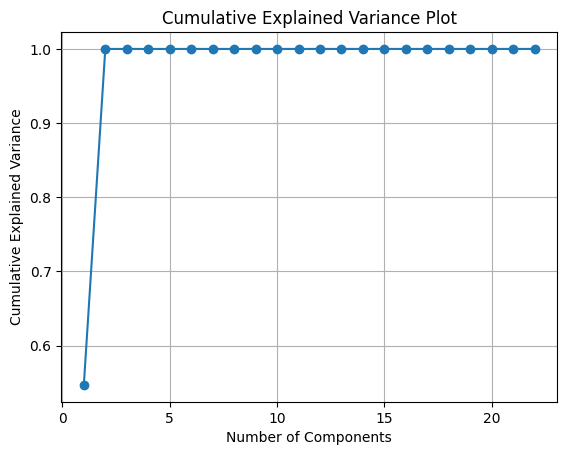

In [ ]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)
# Plot of explained variance vs number of components
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot")
plt.grid(True)
plt.show()

We are selecting a 95% explained variance threshold in PCA to retain a substantial portion of the original data's variance while reducing dimensionality. In the next blocks of code, we apply PCA with this threshold, resulting in X_train_pca, which contains transformed features with reduced dimensionality while preserving 95% of the variance. The "Scree Plot" visualizes the explained variance of each principal component, helping us identify the number of components to retain. Finally, we analyze the loading scores of the top 10 features contributing to the first principal component, which provides insights into the most influential features in the reduced-dimensional space, helping with feature selection and interpretation.

In [ ]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)
print(f"X shape(old shape): {X_train.shape}")
print(f"PCA shape(new shape): {X_train_pca.shape}")

X shape(old shape): (954, 22)
PCA shape(new shape): (954, 2)


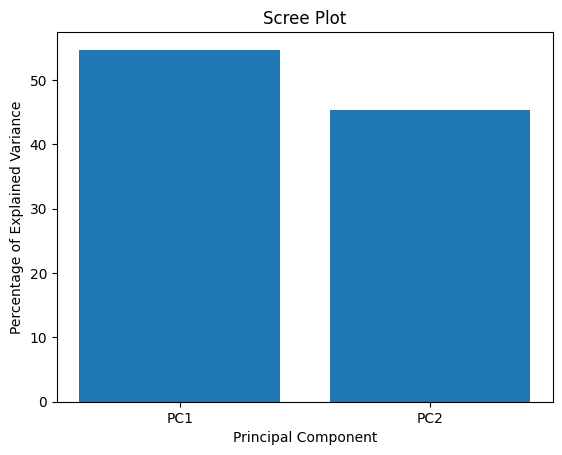

In [ ]:
# Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In [ ]:
# get loading scores
loading_scores = pd.Series(pca.components_[0], index=list(X_test.columns))
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)


top_10 = sorted_loading_scores[0:10].index.values

# print scores
print(loading_scores[top_10])

Ticket                   0.944598
Traveling Together       0.328225
Pclass                   0.001179
Sex_Family_Size_ratio    0.000362
Embarked_Southampton     0.000346
Embarked_Cherbourg      -0.000345
Sex_Parch_ratio          0.000335
Male                     0.000309
Family_Size             -0.000264
Female                  -0.000244
dtype: float64


These scores indicate that the "Ticket" and "Traveling Together" features are by far the most important to PCA.
This is a problem we can face when using an unsupervised form of analysis. PCA is trying to cluster our samples by their positions given by both the ticket and the group that they traveled with. This is not useful at all for our case, since we are trying to predict a label that PCA has no way of understanding with the given features. This is why, for the rest of this work, we will discard this analysis.

### "FIXED" PCA

We noticed that correlated features can indeed lead to the rapid increase in explained variance observed in our scree plot. This behavior is driven by PCA's goal of capturing maximum data variance, which becomes efficient when features are highly correlated, collectively contributing to a substantial portion of the variance. To address this issue and enhance the interpretability of PCA, we removed "Ticket" and "Traveling Together" from the dataset. By doing so, we reduced correlation and redundancy, enabling PCA to emphasize other sources of variance. This adjustment results in a more interpretable PCA outcome, with the main components representing clear patterns in the remaining features.

The removed features, "Ticket" and "Traveling Together" were generated during the feature engineering phase. Their high correlation is primarily attributed to the fact that "Traveling Together" was computed using information from the "Ticket" feature.

[0.44275551 0.63828926 0.77322744 0.85852119 0.92820652 0.95424788
 0.96891465 0.97854873 0.98388449 0.98860826 0.99213136 0.99457887
 0.99651593 0.99775513 0.99883157 0.99932119 0.99967031 0.99992373
 1.         1.        ]


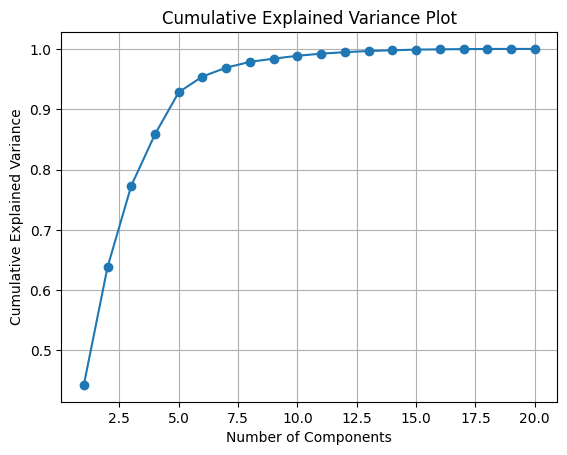

In [ ]:
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.drop(["Ticket", "Traveling Together"], axis=1)
X_test_copy = X_test.copy()
X_test_copy = X_test_copy.drop(["Ticket", "Traveling Together"], axis=1)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_copy)
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)
# Plot of explained variance vs number of components
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Plot")
plt.grid(True)
plt.show()

In [ ]:
## get the loading scores
loading_scores = pd.Series(pca.components_[0], index=list(X_test_copy.columns))
## sort the loading scores
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)


top_10 = sorted_loading_scores[0:10].index.values

## print the names and scores
print(loading_scores[top_10])

Family_Size                0.514750
Sex_Family_Size_ratio     -0.494662
Sex_Parch_ratio           -0.401679
Male                      -0.274863
Parch                      0.263169
SibSp                      0.251580
Female                     0.242763
Pclass                    -0.183339
Parch_Family_Size_ratio   -0.096064
SibSp_Family_Size_ratio   -0.091173
dtype: float64


### LDA

Linear Discriminant Analysis is a dimensionality reduction technique that focuses on finding the linear combinations of features (discriminants) that maximize the separation between multiple classes or categories in a dataset. Unlike PCA, which aims to maximize the overall variance, LDA takes into account the class labels and seeks to maximize the between-class variance while minimizing the class variance. In our problem, applying LDA can be beneficial because it's designed to work well when you have class labels, which we do in our classification task of predicting survival. LDA can also help us improve the interpretability of the transformed features by explicitly maximizing the class separability, making it a suitable choice after observing the results of PCA. It can enhance the discrimination between survivors and non-survivors by finding linear combinations of features that are most informative for the classification task, potentially leading to better model.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

We set the number of components (LDA dimensions) to a maximum of 4 or the minimum between the number of features and one less than the number of classes to avoid overfitting. Then, we fit the LDA model to our training data and transform both the training and testing datasets using the learned transformation. After that, we visualize the one-dimensional LDA projection of our data by plotting it along with the class labels.

In [ ]:
# max allowed value for n_components
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
max_allowed_components = min(n_features, n_classes - 1)

n_components = min(4, max_allowed_components)

# LDA instance with specified number of components
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

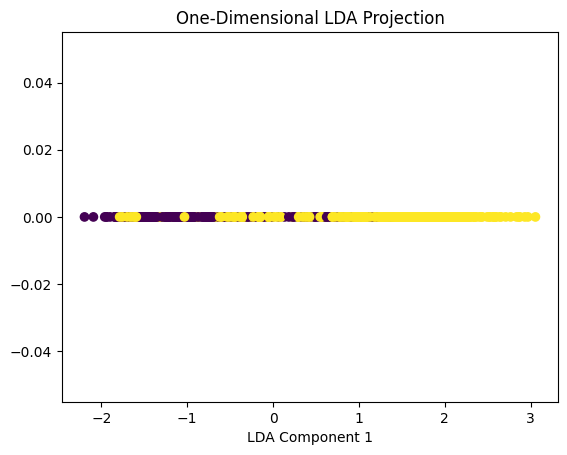

In [ ]:
plt.scatter(X_train_lda, np.zeros_like(X_train_lda), c=y_train, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.title('One-Dimensional LDA Projection')
plt.show()

LDA reduce our dimension to just one, to have a better visualization of the data plor, we plot every value of Y on the X axis in order to see how the data is being clasified

In [ ]:
print(f"X shape(old shape): {X_train.shape}")
print(f"LDA shape(new shape): {X_train_lda.shape}")
lda.explained_variance_ratio_

X shape(old shape): (954, 22)
LDA shape(new shape): (954, 1)


array([1.])

LDA reduces to only one dimension in this case because we have a binary classification problem with two classes. In LDA, the number of dimensions is defined by the number of classes minus one. Since we have two classes, LDA reduces the dimensionality to one to maximize the separation between the two classes along a single axis.

## 2.1 Classifers

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

splitting for local accuracy

In [ ]:
X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

The eval_predictions function is designed for evaluating the performance of a binary classification model. It takes the predicted labels (y_pred) and the true labels (y_test) as inputs and computes various classification metrics, including accuracy, precision, and recall for both classes(survivors and deceased). It then generates a confusion matrix to visualize the model's performance in classifying the data.

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()

    return accuracy, precision, recall, f1, TN, FP, FN, TP
def eval_predictions(y_pred, y_test, title = "Confusion Matrix"):
    conf_matrix = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_pred, y_test)
    survivors_precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    survivors_recall = conf_matrix[0][0] / np.sum(conf_matrix[0])
    deceased_precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
    deceased_recall = conf_matrix[1][1] / np.sum(conf_matrix[1])

    print(f"Accuracy score: %.2f" %(accuracy))
    print(f"Survivors precision: %.2f" %(survivors_precision))
    print(f"Survivors recall: %.2f" %(survivors_recall))
    print(f"Deceased precision: %.2f" %(deceased_precision))
    print(f"Deceased recall: %.2f" %(deceased_recall))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Survivors", "Deceased"], yticklabels=["Survivors", "Deceased"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

def get_roc(y_test, y_proba, allowed_fpr=0.15):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    fpr_index = 0
    for i in range(len(fpr)):
        if fpr[i] > allowed_fpr:
            fpr_index = i-1
            break

    print(f"The threshold for the given allowed_fpr is: %.4f" %(thresholds[fpr_index]))
    print(f"Resulting in a tpr of: %.4f" %(tpr[fpr_index]))

    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return thresholds[fpr_index]

This analyze_grid_results function is designed to analyze and visualize the results of hyperparameter tuning, typically performed through techniques like grid search or cross-validation. It takes the cross-validation results (cv_res) as input and extracts performance metrics such as test scores, standard deviations, and parameter configurations. It then organizes and sorts these metrics to identify the top-performing parameter configurations. The function generates visualizations, including bar plots for standard deviations and aggregate performance scores, and an error bar plot to provide a comprehensive overview of how different parameter settings affect model performance. This function aids in selecting the best hyperparameters for a machine learning model by providing insights into their impact on performance.

In [ ]:
def analyze_grid_results(cv_res, n_max_params=5):
    splits = []
    col_names = []
    for i in range(cv):
        col_names.append('split'+str(i)+'_test_score')
        splits.append(cv_res[col_names[-1]])

    splits.append(cv_res['mean_test_score'])
    splits.append(cv_res['std_test_score'])

    col_names.append('Aggregate performance')
    col_names.append('std')

    if len(cv_res['params']) < n_max_params:
        n_params = len(cv_res['params'])
    else:
        n_params = n_max_params

    splits = pd.DataFrame(splits, columns=[str(d) for d in cv_res['params']], index=col_names).T
    splits = splits.sort_values('Aggregate performance', ascending=False)[0:n_params]

    scores = np.array([])
    param_index = np.array([])

    for i in range(n_params):
        print(str(i)+ " - " + str(splits.index[i]) + " - AggP: " + str(splits['Aggregate performance'].iloc[i]))
        scores = np.concatenate([scores, splits.drop(['Aggregate performance', 'std'], axis=1).iloc[i].to_numpy()])
        param_index = np.concatenate([param_index, np.repeat(i, len(col_names)-2)])

    eb_df = pd.DataFrame([scores, param_index], index=["Score", "Parameter index"]).T
    eb_df

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    #sns.histplot(splits, x=)
    axes[0].bar(range(n_params), splits.T.loc["std"].to_numpy(), color=sns.color_palette(n_colors=n_params))
    axes[0].set_xticks(range(n_params))
    axes[0].set_xlabel("Parameter index")
    axes[0].set_ylabel("Standard Deviation")
    axes[0].set_title("Standard Deviation for each set of params")

    axes[1].bar(range(n_params), splits.T.loc["Aggregate performance"].to_numpy(), color=sns.color_palette(n_colors=n_params))
    axes[1].set_xticks(range(n_params))
    axes[1].set_xlabel("Parameter index")
    axes[1].set_ylabel("Aggregate performance")
    axes[1].set_title("Aggregate performance for each set of params")

    #axes[2].errorbar()
    sns.barplot(ax=axes[2], data=eb_df, x='Parameter index', y='Score')
    axes[2].set_title("Error bars for results of each set of params")
    plt.show()
    return splits;

### Stratified K-Fold Cross Validation

KFold cross-validation is particularly useful in our case when assessing the generalization performance of our machine learning models. It helps us prevent overfitting by splitting our dataset into multiple subsets, training our models on different partitions, and evaluating their performance. In the code provided, we are using StratifiedKFold with five splits (n_splits=5). This variant of KFold ensures that each fold maintains the same class distribution as the original dataset, which is crucial when dealing with imbalanced datasets like the Titanic dataset. However, in our specific model training workflow, we are not explicitly using KFold because we have opted for grid search with cross-validation. Grid search automatically applies cross-validation to evaluate different combinations of hyperparameters, making it unnecessary to manually implement KFold. This approach allows us to efficiently search for the best hyperparameters while ensuring robust model evaluation.

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)

5

### LDA

In [ ]:
from sklearn.model_selection import GridSearchCV

Here we are using LDA as a classification model. We perform hyperparameter tuning using a grid search approach. The hyperparameters being evaluated within the grid search are the "solver" and "shrinkage" parameters. The "solver" parameter determines the algorithm used to compute the LDA transformation, with options like "svd", "lsqr" and "eigen". The "shrinkage" parameter is used to regularize the covariance matrix, and we explore different values for it. The grid search, with 5-fold cross-validation (cv=5).

In [ ]:
cv = 5
param_grid = [{'solver':['svd']} ,{'solver':['lsqr', 'eigen'], 'shrinkage':['auto', 0.1, 0.5, 0.9]}]
lda = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(lda, param_grid, cv=cv)
grid_search.fit(X=X_train, y=y_train)

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid=[{'solver': ['svd']},
                         {'shrinkage': ['auto', 0.1, 0.5, 0.9],
                          'solver': ['lsqr', 'eigen']}])

0 - {'shrinkage': 'auto', 'solver': 'lsqr'} - AggP: 0.8197519977955359
1 - {'shrinkage': 'auto', 'solver': 'eigen'} - AggP: 0.8197519977955359
2 - {'solver': 'svd'} - AggP: 0.8166051253788924
3 - {'shrinkage': 0.9, 'solver': 'lsqr'} - AggP: 0.6383742077707357
4 - {'shrinkage': 0.9, 'solver': 'eigen'} - AggP: 0.6383742077707357


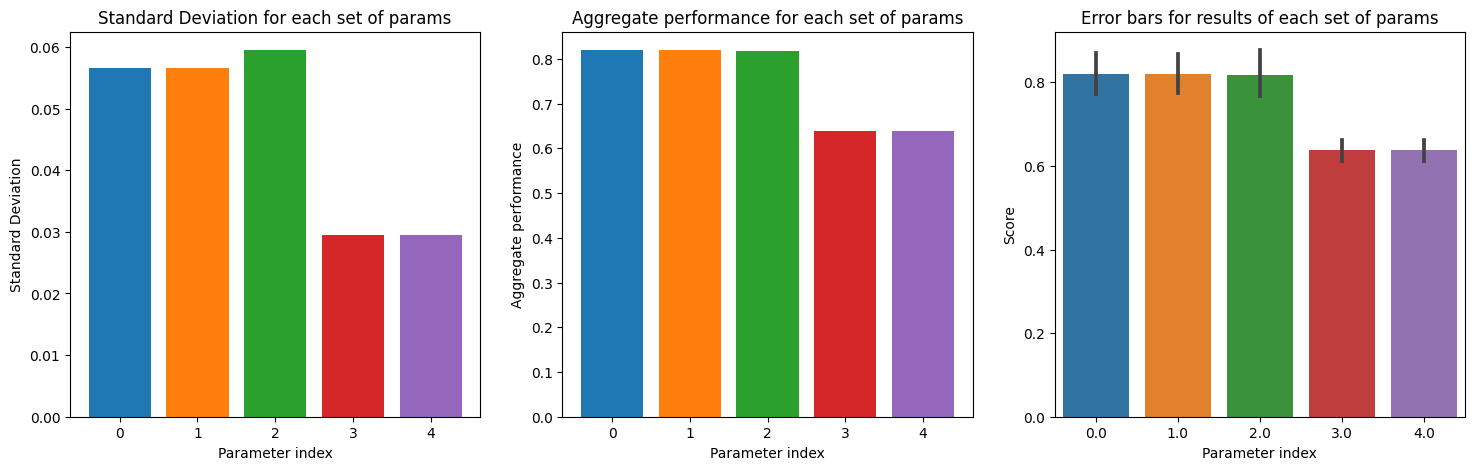

In [ ]:
lda_cv_res = grid_search.cv_results_
splits = analyze_grid_results(lda_cv_res)

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.82
From model:


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

Now that we have our winning model, we train it with local train-test split to analyze the metrics. This metrics will give us an idea of things such as biases, accuracies and overall performance. Taking in care the Kaggle results, we can say that the model did not overfitted, in comparison to rest of the models; due to

The accuracy score of 0.81 suggests a reasonably accurate classification. However, the precision for survivors 0.75 and deceased 0.88 indicates moderate to high bias, which means that there might be a trade-off between correctly identifying survivors and deceased passengers. Additionally, the recall for survivors (0.89) is relatively high, while the recall for deceased 0.73 is moderate, indicating a moderate level of variance in the model's ability to capture true positive cases. These results suggest a good fit without significant underfitting or overfitting.

Accuracy score: 0.81
Survivors precision: 0.75
Survivors recall: 0.89
Deceased precision: 0.88
Deceased recall: 0.73


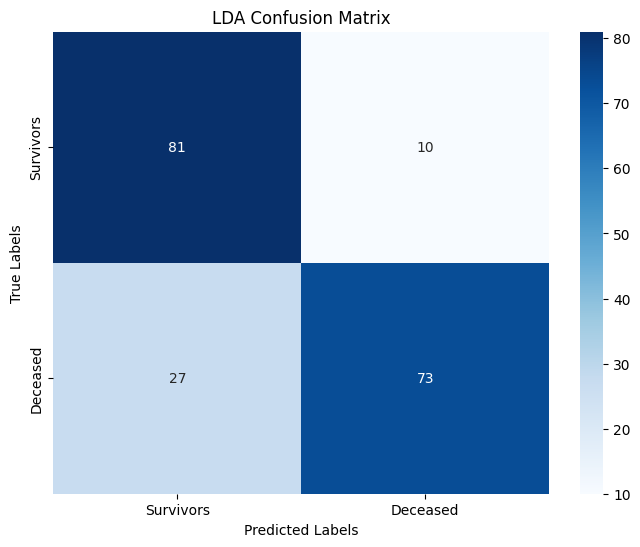

In [ ]:
lda = grid_search.best_estimator_
lda.fit(X_train_local, y_train_local)
lda_pred = lda.predict(X_test_local)
lda_proba = lda.predict_proba(X_test_local)[:, 1]
eval_predictions(lda_pred, y_test_local, title="LDA Confusion Matrix")

This is the confusion matrix with the X_train_local data we have and the best_estimators for LDA, the result is that have an accuracy of

The threshold for the given allowed_fpr is: 0.2964
Resulting in a tpr of: 0.8400


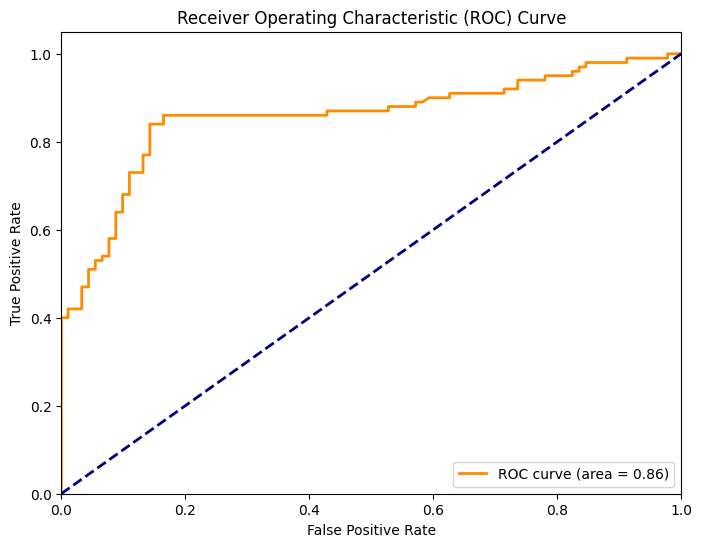

In [ ]:
roc_threshold = get_roc(y_test_local, lda_proba, allowed_fpr=0.15)

We can clearly see that, although our model performed well, it shows a bias towards the survived class. However, the deceased precision and survived recall is high among our models, meaning that this model is great at avoiding wrongfully labeling survived samples as deceased.

Accuracy score: 0.84
Survivors precision: 0.82
Survivors recall: 0.86
Deceased precision: 0.86
Deceased recall: 0.83


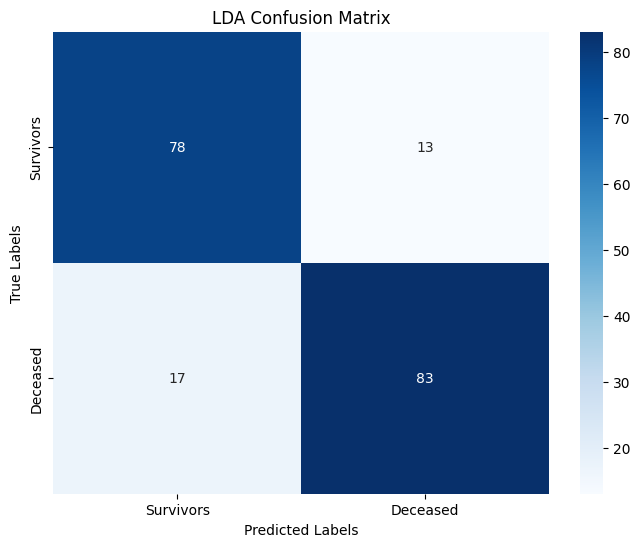

In [ ]:
lda = grid_search.best_estimator_
lda.fit(X_train_local, y_train_local)
lda_proba = lda.predict_proba(X_test_local)[:,1]
lda_pred = np.array([int(proba > roc_threshold) for proba in lda_proba])
eval_predictions(lda_pred, y_test_local, title="LDA Confusion Matrix")

The accuracy score of 0.84 indicates a reasonable classification. The precision scores suggest a balanced model with relatively low bias,  identifying most cases. The recall scores indicate a good balance between capturing true positives, which demonstrating a moderate level of variance. The model achieves a good fit with an small ammount of  underfitting / overfitting, to strike a balance between bias and variance.

We proceed to train our model with X_train to predict X_test for Kaggle.

In [ ]:
lda = grid_search.best_estimator_
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)
df = pd.DataFrame(lda_pred, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("lda_submission.csv")

In [ ]:
lda_proba = lda.predict_proba(X_test)
lda_pred_roc = np.array([int(proba[1] > roc_threshold) for proba in lda_proba])
df = pd.DataFrame(lda_pred_roc, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("lda_roc_submission.csv")

Storing LDA components to train the following models.

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_train_local_lda = lda.transform(X_train_local)
X_test_local_lda = lda.transform(X_test_local)

### Naive Bayes

We are employing the Gaussian Naive Bayes classifier in our analysis. The grid search involves tuning the 'priors' and 'var_smoothing' hyperparameters. The 'priors' parameter allows us to specify prior probabilities for the classes, which we set to 'None' in this grid. The 'var_smoothing' parameter is responsible for adding smoothing to variance, preventing division by zero. We explore various smoothing values, such as 1e-9, 1e-8, 1e-7, and 1e-6, to identify the optimal configuration. The grid search, performed with 5-fold cross-validation (cv=5), systematically evaluates these hyperparameters to find the most suitable settings for our Gaussian Naive Bayes classifier.

**Why would we choose Naive Bayes?**

The most important characteristic we believe Naive Bayes will be usefull for is its assumption of independence between features. While we do have many features that are clearly dependant from one ore more features (like the ratios), we are malink a bet on the LDA components. Since this is a binary classification problem, LDA will only output one component, guaranteeing said independence from other features. We will, however, still train the model with the precessed features, since this model is still efficient and simple.

In [ ]:
from sklearn.naive_bayes import GaussianNB

param_grid = {
    'priors': [None, [deceased_proba, survived_proba]],
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}
gnb = GaussianNB()
cv = 5
grid_search = GridSearchCV(gnb, param_grid, cv=cv)
grid_search.fit(X=X_train, y=y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'priors': [None,
                                    [0.6202860858257477, 0.37971391417425226]],
                         'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]})

0 - {'priors': None, 'var_smoothing': 1e-06} - AggP: 0.7945549738219896
1 - {'priors': [0.6202860858257477, 0.37971391417425226], 'var_smoothing': 1e-07} - AggP: 0.7924607329842932
2 - {'priors': None, 'var_smoothing': 1e-07} - AggP: 0.791413612565445
3 - {'priors': [0.6202860858257477, 0.37971391417425226], 'var_smoothing': 1e-06} - AggP: 0.7903664921465967
4 - {'priors': None, 'var_smoothing': 1e-08} - AggP: 0.7840947919537062


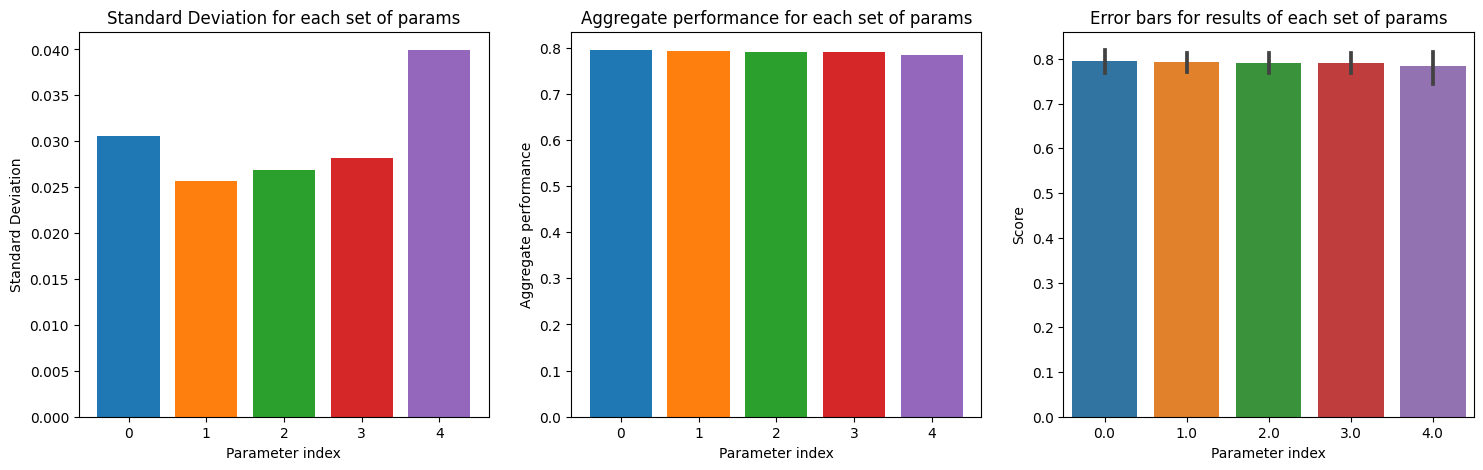

In [ ]:
gnb_cv_res = grid_search.cv_results_
splits = analyze_grid_results(gnb_cv_res)

In [ ]:
grid_search.best_score_

0.7945549738219896

The grid search process revealed that the model with var_smoothing set to 1e-06 achieved the highest aggregate performance score of approximately 0.79 on the validation data.

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.79
From model:


GaussianNB(var_smoothing=1e-06)

Accuracy score: 0.77
Survivors precision: 0.74
Survivors recall: 0.80
Deceased precision: 0.80
Deceased recall: 0.74


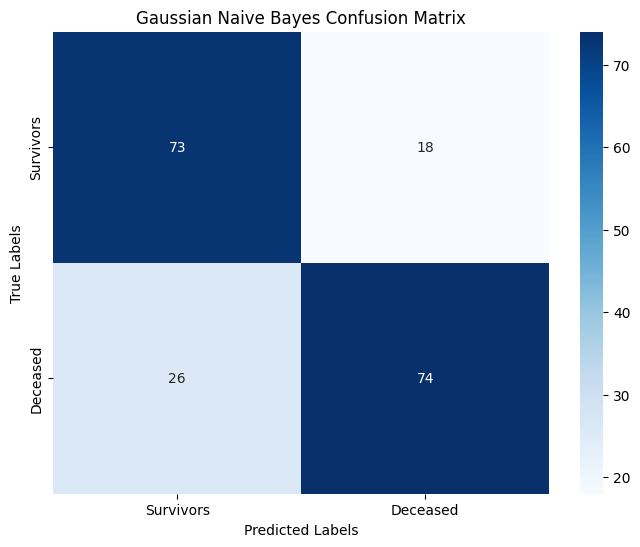

In [ ]:
gnb = GaussianNB(priors=[deceased_proba, survived_proba], var_smoothing=1e-07)
gnb.fit(X_train_local, y_train_local)
gnb_pred = gnb.predict(X_test_local)
gnb_proba = gnb.predict_proba(X_test_local)[:,1]
eval_predictions(gnb_pred, y_test_local, title="Gaussian Naive Bayes Confusion Matrix")

When evaluating the selected GNB model with var_smoothing=1e-06 on the test data, it resulted with an accuracy score of 0.79. The confusion matrix analysis also indicates a balanced performance, with precision scores of 0.75 for survivors and 0.83 for deceased passengers, along with recall scores of 0.84 for survivors and 0.74 for deceased passengers.

The threshold for the given allowed_fpr is: 0.0049
Resulting in a tpr of: 0.8300


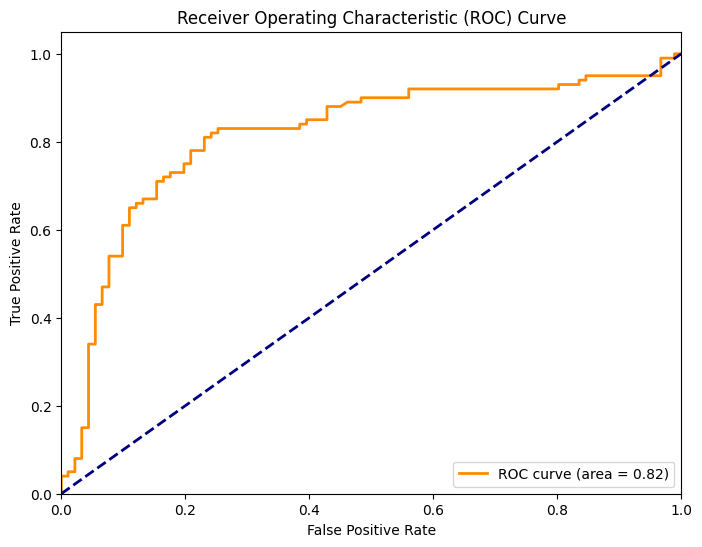

In [ ]:
roc_threshold = get_roc(y_test_local, gnb_proba, 0.3)

In [ ]:
gnb = GaussianNB(priors=[deceased_proba, survived_proba], var_smoothing=1e-07)
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
df = pd.DataFrame(gnb_pred, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("gnb_submission.csv")

In [ ]:
grid_search.fit(X=X_train_lda, y=y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'priors': [None,
                                    [0.6202860858257477, 0.37971391417425226]],
                         'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]})

0 - {'priors': None, 'var_smoothing': 1e-09} - AggP: 0.827076329567374
1 - {'priors': None, 'var_smoothing': 1e-08} - AggP: 0.827076329567374
2 - {'priors': None, 'var_smoothing': 1e-07} - AggP: 0.827076329567374
3 - {'priors': None, 'var_smoothing': 1e-06} - AggP: 0.827076329567374
4 - {'priors': [0.6202860858257477, 0.37971391417425226], 'var_smoothing': 1e-09} - AggP: 0.8260402314687241


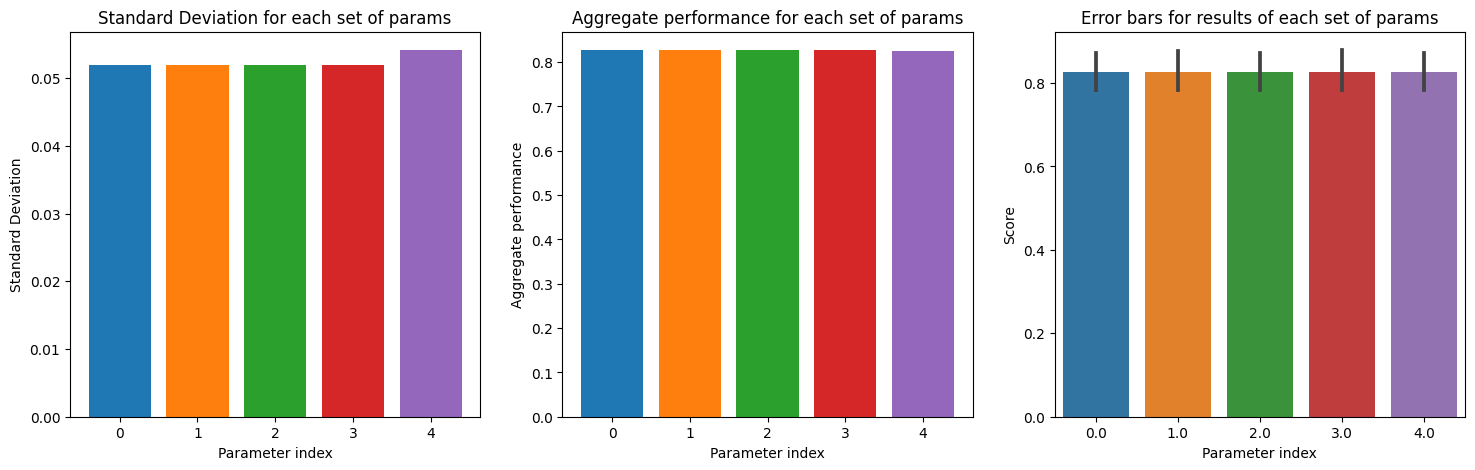

In [ ]:
gnb_lda_cv_res = grid_search.cv_results_
splits = analyze_grid_results(gnb_lda_cv_res)

Interestingly, all tested var_smoothing values (ranging from 1e-09 to 1e-06) resulted in the same high aggregate performance score of approximately 0.83. This suggests that the GNB model with LDA components provides consistent and strong classification performance

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.83
From model:


GaussianNB()

Accuracy score: 0.81
Survivors precision: 0.75
Survivors recall: 0.89
Deceased precision: 0.88
Deceased recall: 0.73


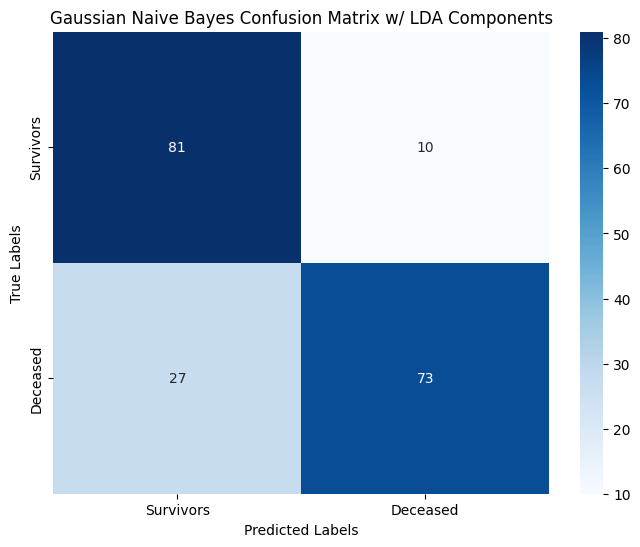

In [ ]:
gnb_lda = GaussianNB(priors=[deceased_proba, survived_proba], var_smoothing=1e-09)
gnb_lda.fit(X_train_local_lda, y_train_local)
gnb_lda_pred = gnb_lda.predict(X_test_local_lda)
gnb_lda_proba = gnb_lda.predict_proba(X_test_local_lda)[:,1]
eval_predictions(gnb_lda_pred, y_test_local, title="Gaussian Naive Bayes Confusion Matrix w/ LDA Components")

When evaluating the selected GNB model with the best var_smoothing parameter (1e-09) on the test data, it achieved an accuracy score of 0.81, indicating its effectiveness. The confusion matrix analysis shows that the model is somewhat more balanced that previous models, with precision scores of 0.76 for survivors and 0.88 for deceased passengers, along with recall scores of 0.89 for survivors and 0.74 for deceased passengers. It does, however, still hold a significant bias towards survivors.

The threshold for the given allowed_fpr is: 0.1602
Resulting in a tpr of: 0.8600


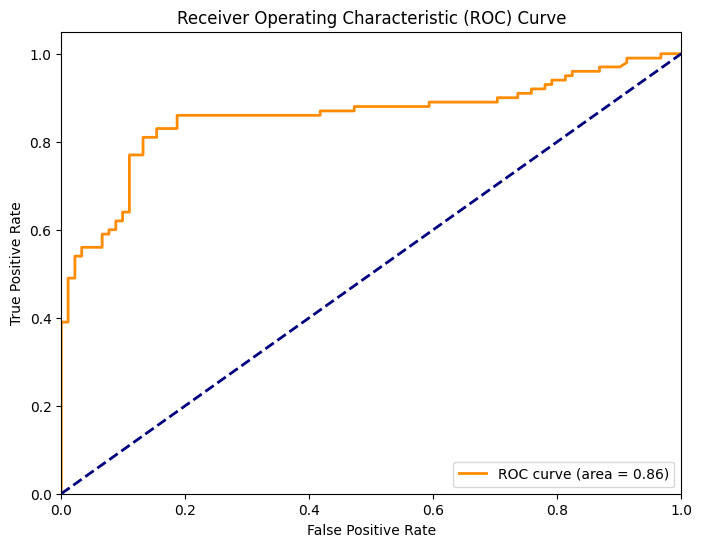

0.16022632474867599

In [ ]:
get_roc(y_test_local, gnb_lda_proba, 0.25)

The results of this model were promising. The area under the curve also displayed great values. That's why, for this specific instance, we tried to use the ROC to determine a new threshold to classify the data. This threshold was chosen with the elbow method: we determined that somewhere between 0.2 and 0.4 FPR relied a good threshold. We then used this threshold to reinterpret previous results and analyze the given metrics.

Accuracy score: 0.76
Survivors precision: 0.75
Survivors recall: 0.76
Deceased precision: 0.78
Deceased recall: 0.77


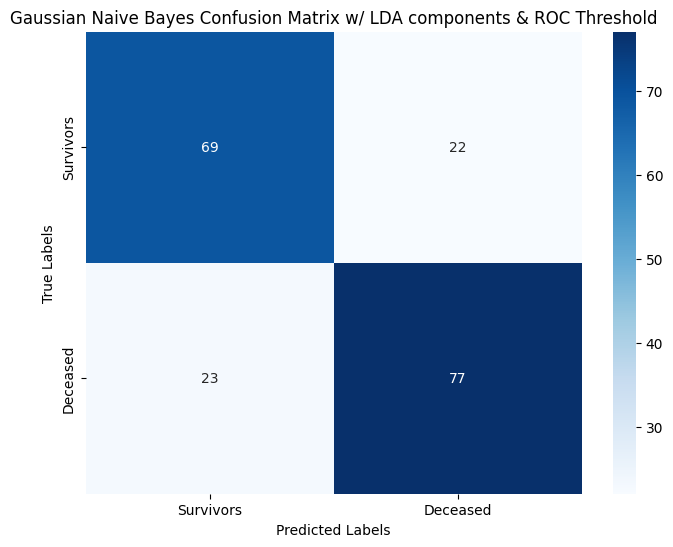

In [ ]:
gnb_lda = GaussianNB(priors=[deceased_proba, survived_proba], var_smoothing=1e-09)
gnb_lda.fit(X_train_local, y_train_local)
gnb_lda_proba = gnb_lda.predict_proba(X_test_local)[:,1]
gnb_lda_pred = np.array([int(proba > roc_threshold) for proba in gnb_lda_proba])
eval_predictions(gnb_lda_pred, y_test_local, title="Gaussian Naive Bayes Confusion Matrix w/ LDA components & ROC Threshold")

These results show that, while the bias towards survivors fell, so did the overall accuracy of the model. For this specific case, the threshold might be useful to generalize, but it decreased the accuracy to a point where is not as viable to use as we previously thought.

In [ ]:
gnb_lda = GaussianNB(priors=[deceased_proba, survived_proba], var_smoothing=1e-09)
gnb_lda.fit(X_train_lda, y_train)
gnb_lda_pred = gnb_lda.predict(X_test_lda)
df = pd.DataFrame(gnb_lda_pred, index=X_test.index, columns=["Survived"]) #index=X_test_lda.index
df.index.name = "PassengerId"
df.to_csv("gnb_lda_submission.csv")

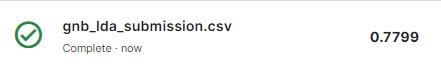

In [ ]:
gnb_lda_proba = gnb_lda.predict_proba(X_test_lda)[:,1]
gnb_lda_pred = np.array([int(proba > roc_threshold) for proba in gnb_lda_proba])
df = pd.DataFrame(gnb_lda_pred, index=X_test.index, columns=["Survived"]) #index=X_test_lda.index
df.index.name = "PassengerId"
df.to_csv("gnb_lda_roc_submission.csv")

Overall, Gaussian Naive Bayes showed a great performance. The model trained with LDA components was the highest of our scores when it came to the Kaggle test score. It shows little signs of overfitting, since the Kaggle scores are close within reason to the ones given by K-Fold CV and our train split.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

We're utilizing Random Forest classifier, that combines multiple decision trees, for our analysis. The grid search examines "n_estimators" to determine the number of trees in the forest, "max_depth" to control the maximum depth of each tree, "bootstrap" to indicate whether bootstrapping should be used, and "random_state" for reproducibility. We consider different values for these hyperparameters, such as the number of estimators (100, 150, 200), maximum tree depth (20, 40, 60, None), bootstrap (True, False), and a fixed random state (42). The grid search, conducted with 5-fold cross-validation (cv=5).



In [ ]:
param_grid = [{'n_estimators': [100, 150, 200], 'max_depth':[20, 40, 60, None], 'bootstrap':[True, False], 'random_state':[42]}]
random_f = RandomForestClassifier()
grid_search = GridSearchCV(random_f, param_grid, cv=cv)
grid_search.fit(X=X_train, y=y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [20, 40, 60, None],
                          'n_estimators': [100, 150, 200],
                          'random_state': [42]}])

0 - {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200, 'random_state': 42} - AggP: 0.8585285202535132
1 - {'bootstrap': True, 'max_depth': 20, 'n_estimators': 100, 'random_state': 42} - AggP: 0.8585230090934142
2 - {'bootstrap': True, 'max_depth': 40, 'n_estimators': 200, 'random_state': 42} - AggP: 0.8574813998346651
3 - {'bootstrap': True, 'max_depth': 60, 'n_estimators': 200, 'random_state': 42} - AggP: 0.8574813998346651
4 - {'bootstrap': True, 'max_depth': None, 'n_estimators': 200, 'random_state': 42} - AggP: 0.8574813998346651
5 - {'bootstrap': True, 'max_depth': 40, 'n_estimators': 100, 'random_state': 42} - AggP: 0.8574758886745661


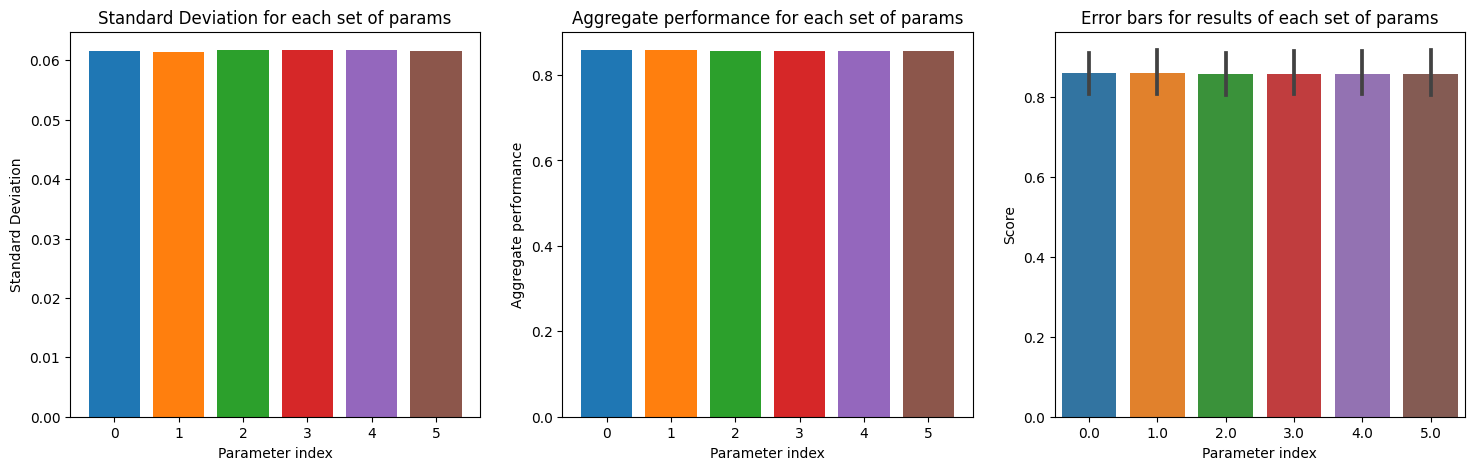

In [ ]:
rf_cv_res = grid_search.cv_results_
splits = analyze_grid_results(rf_cv_res, n_max_params=6)

In [ ]:
grid_search.best_score_

0.8585285202535132

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.86
From model:


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

Accuracy score: 0.86
Survivors precision: 0.84
Survivors recall: 0.87
Deceased precision: 0.88
Deceased recall: 0.85


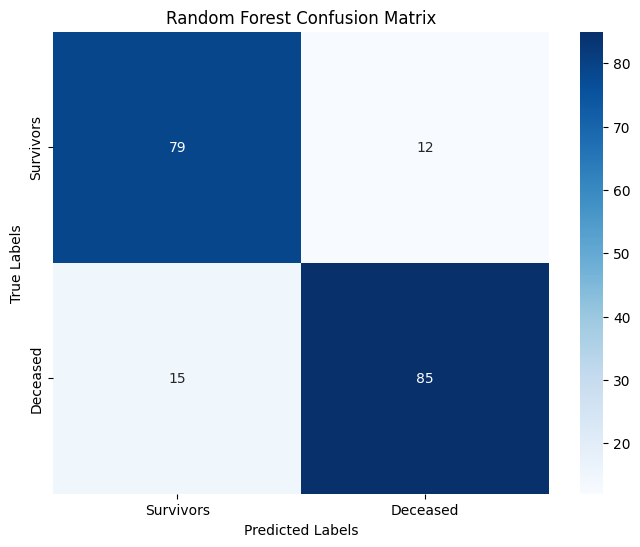

In [ ]:
random_f = grid_search.best_estimator_
random_f.fit(X_train_local, y_train_local)
random_f_pred = random_f.predict(X_test_local)
random_f_proba = random_f.predict_proba(X_test_local)[:,1]
eval_predictions(random_f_pred, y_test_local, title="Random Forest Confusion Matrix")

The threshold for the given allowed_fpr is: 0.4500
Resulting in a tpr of: 0.8600


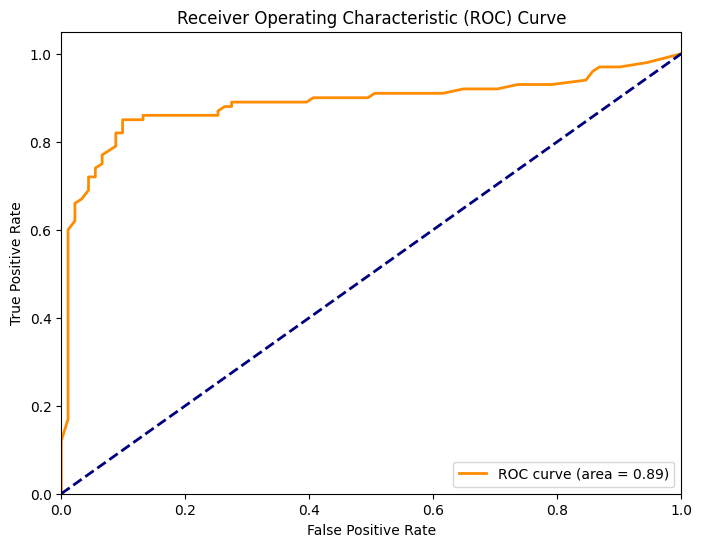

0.45

In [ ]:
get_roc(y_test_local, random_f_proba)

The model exhibits strong performance with an accuracy score of 0.86. Both classes' precision and recall scores are well-balanced, indicating a relatively low degree of bias, and the model effectively captures true positives while minimizing false negatives. The general balance between precision and recall suggests a balanced level of variance. This equilibrium between bias and variance tells us that the KNN model is well-fitted to the data and based on some tests in kaggle, we would say its overfitted.

In [ ]:
random_f = grid_search.best_estimator_
random_f.fit(X_train, y_train)
random_f_pred = random_f.predict(X_test)
df = pd.DataFrame(random_f_pred, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("random_f_submission.csv")

In [ ]:
grid_search.fit(X=X_train_lda, y=y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [20, 40, 60, None],
                          'n_estimators': [100, 150, 200],
                          'random_state': [42]}])

0 - {'bootstrap': False, 'max_depth': 20, 'n_estimators': 100, 'random_state': 42} - AggP: 0.7799063102783135
1 - {'bootstrap': False, 'max_depth': 20, 'n_estimators': 150, 'random_state': 42} - AggP: 0.7799063102783135
2 - {'bootstrap': False, 'max_depth': 20, 'n_estimators': 200, 'random_state': 42} - AggP: 0.7799063102783135
3 - {'bootstrap': False, 'max_depth': None, 'n_estimators': 150, 'random_state': 42} - AggP: 0.7746596858638742
4 - {'bootstrap': False, 'max_depth': None, 'n_estimators': 100, 'random_state': 42} - AggP: 0.7746596858638742
5 - {'bootstrap': False, 'max_depth': 60, 'n_estimators': 200, 'random_state': 42} - AggP: 0.7746596858638742
6 - {'bootstrap': False, 'max_depth': 60, 'n_estimators': 150, 'random_state': 42} - AggP: 0.7746596858638742
7 - {'bootstrap': False, 'max_depth': 60, 'n_estimators': 100, 'random_state': 42} - AggP: 0.7746596858638742
8 - {'bootstrap': False, 'max_depth': 40, 'n_estimators': 200, 'random_state': 42} - AggP: 0.7746596858638742
9 - {'

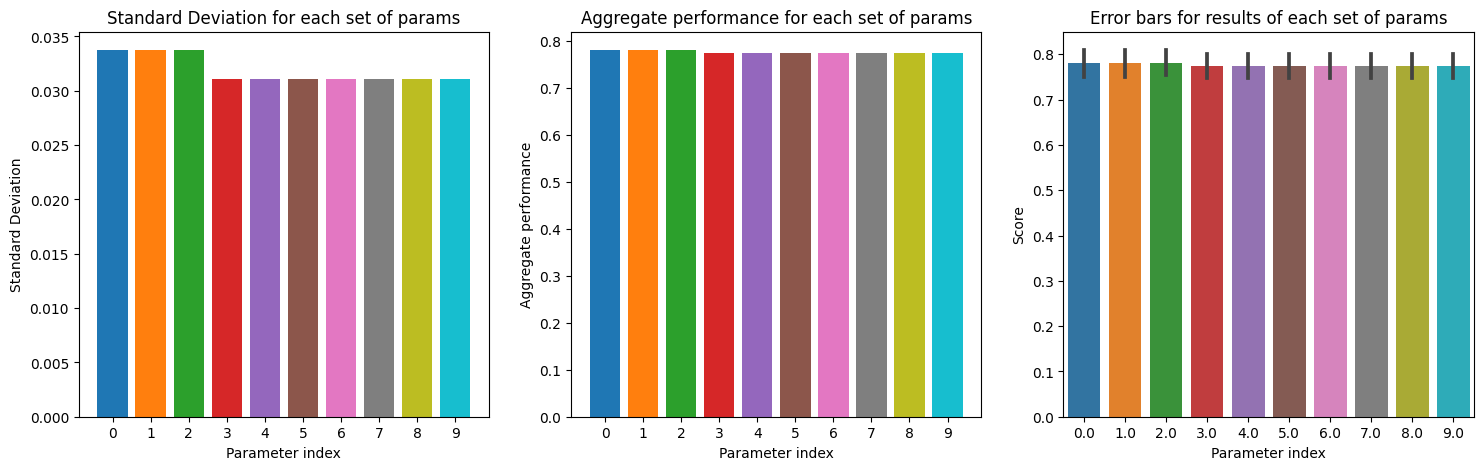

In [ ]:
rf_lda_cv_res = grid_search.cv_results_
splits = analyze_grid_results(rf_lda_cv_res, n_max_params=10)

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.78
From model:


RandomForestClassifier(bootstrap=False, max_depth=20, random_state=42)

Accuracy score: 0.71
Survivors precision: 0.67
Survivors recall: 0.77
Deceased precision: 0.76
Deceased recall: 0.65


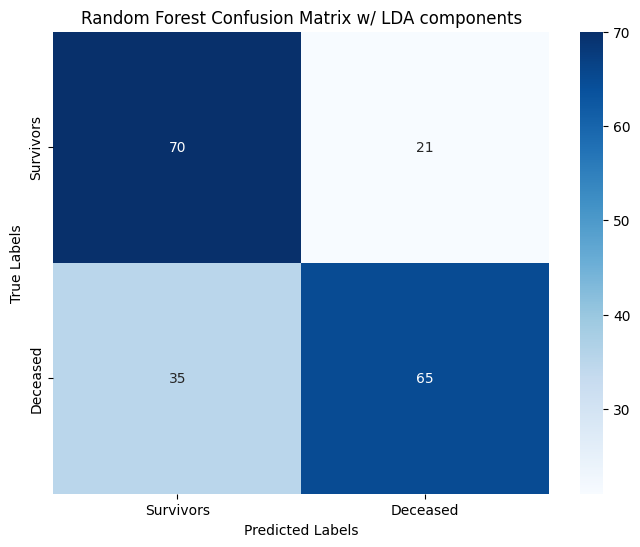

In [ ]:
random_f_lda = grid_search.best_estimator_
random_f_lda.fit(X_train_local_lda, y_train_local)
random_f_lda_pred = random_f_lda.predict(X_test_local_lda)
random_f_lda_proba = random_f_lda.predict_proba(X_test_local_lda)[:,1]
eval_predictions(random_f_lda_pred, y_test_local, title="Random Forest Confusion Matrix w/ LDA components")

The threshold for the given allowed_fpr is: 2.0000
Resulting in a tpr of: 0.0000


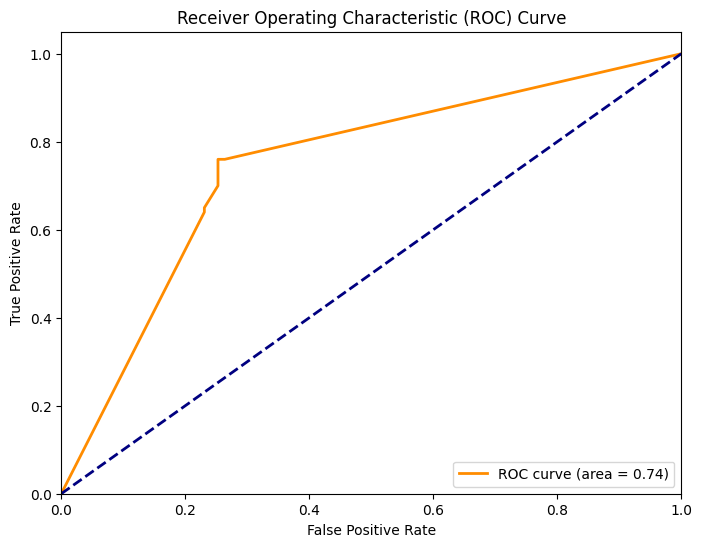

2.0

In [ ]:
get_roc(y_test_local, random_f_lda_proba)

In [ ]:
random_f_lda = grid_search.best_estimator_
random_f_lda.fit(X_train_lda, y_train)
random_f_lda_pred = random_f_lda.predict(X_test_lda)
df = pd.DataFrame(random_f_lda_pred, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("random_f_lda_submission.csv")

In the Accuracy score of Random Forest with our LDA were higher from the one with LDA, this is because random forest need features in order have a better classification, the recall indicate a good balance between both classes, indicating that this is a good classification also thanks that Random Forest is a good method to deal with overfitting and large amount of features that is the case in this dataset. The confusion matrix exhibits that this model has a bias towards decead people as survivors.

### K Nearest Neighbors

For the KNN classifier, we're conducting a grid search to optimize its performance. KNN is a non-parametric classification algorithm that relies on the number of neighbors and the weighting scheme. In this grid search, we're varying the number of neighbors from 1 to 21 and considering both uniform and distance-based weighting schemes. The grid search is performed with 5-fold cross-validation (cv=5).

In [ ]:
param_grid = {
    'n_neighbors': range(1, 30, 2),
    'weights': ["uniform", "distance"],
}
knn = KNeighborsClassifier()
cv = 5
grid_search = GridSearchCV(knn, param_grid, cv=cv)
grid_search.fit(X=X_train, y=y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30, 2),
                         'weights': ['uniform', 'distance']})

0 - {'n_neighbors': 7, 'weights': 'distance'} - AggP: 0.7243317718379719
1 - {'n_neighbors': 19, 'weights': 'distance'} - AggP: 0.7222650868007715
2 - {'n_neighbors': 21, 'weights': 'distance'} - AggP: 0.7201598236428768
3 - {'n_neighbors': 11, 'weights': 'distance'} - AggP: 0.7191127032240286
4 - {'n_neighbors': 23, 'weights': 'distance'} - AggP: 0.7180710939652798
5 - {'n_neighbors': 29, 'weights': 'distance'} - AggP: 0.7180655828051805
6 - {'n_neighbors': 9, 'weights': 'distance'} - AggP: 0.7180655828051805
7 - {'n_neighbors': 25, 'weights': 'distance'} - AggP: 0.7180600716450813
8 - {'n_neighbors': 17, 'weights': 'distance'} - AggP: 0.7170294847065307
9 - {'n_neighbors': 27, 'weights': 'distance'} - AggP: 0.7159603196472857


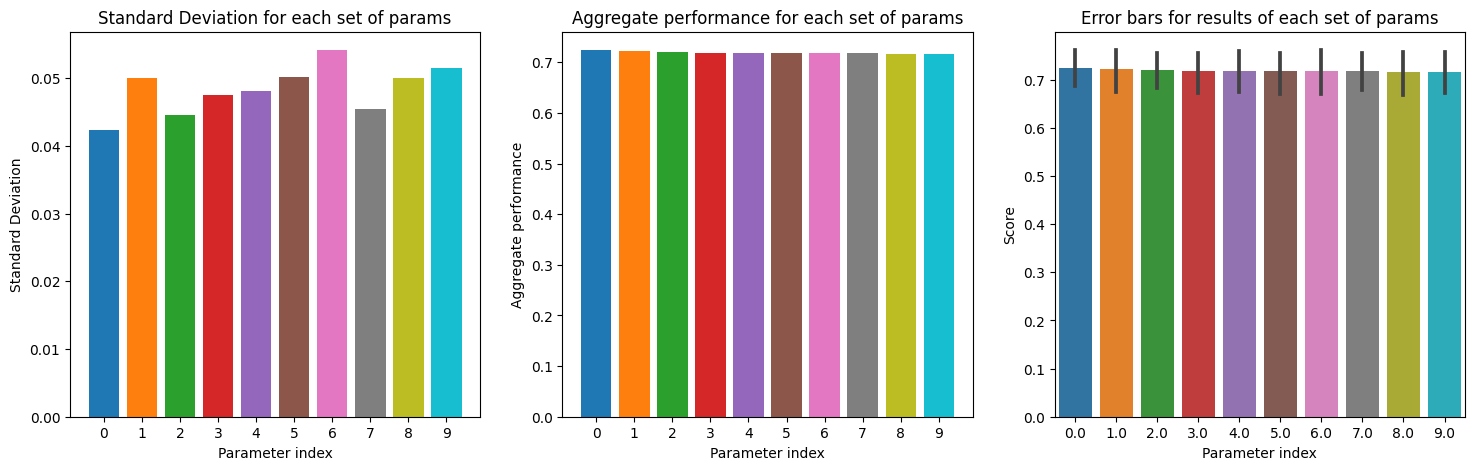

In [ ]:
knn_cv_res = grid_search.cv_results_
splits = analyze_grid_results(knn_cv_res, n_max_params=10)

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.72
From model:


KNeighborsClassifier(n_neighbors=7, weights='distance')

Accuracy score: 0.76
Survivors precision: 0.76
Survivors recall: 0.75
Deceased precision: 0.77
Deceased recall: 0.78


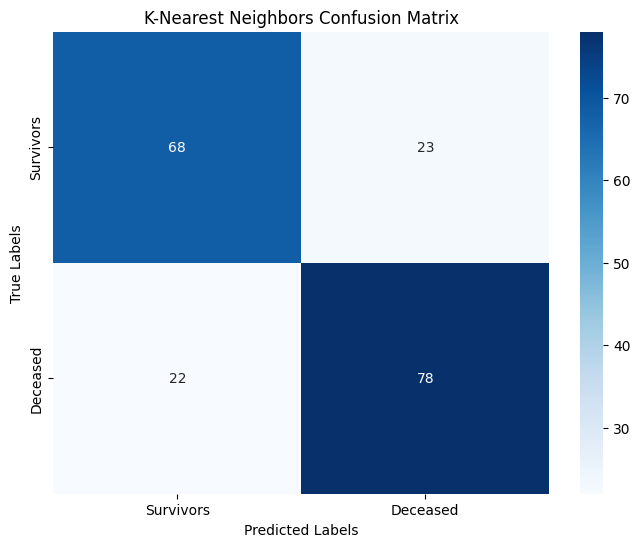

In [ ]:
knn = grid_search.best_estimator_
knn.fit(X_train_local, y_train_local)
knn_pred = knn.predict(X_test_local)
knn_proba = knn.predict_proba(X_test_local)[:,1]
eval_predictions(knn_pred, y_test_local, title="K-Nearest Neighbors Confusion Matrix")

The accuracy score of 0.76 somewhat accurate classification.  Survivors and deceased's precision and recall scores are consistent and balanced, suggesting a moderate level of bias with the model. The relatively lower precision and recall scores compared to the accuracy score indicate a moderate level of variance, meaning there is room for improvement in capturing true positives and reducing false negatives. Overall, the model exhibits that its maintaining a balance between bias and variance.

The threshold for the given allowed_fpr is: 0.7456
Resulting in a tpr of: 0.5300


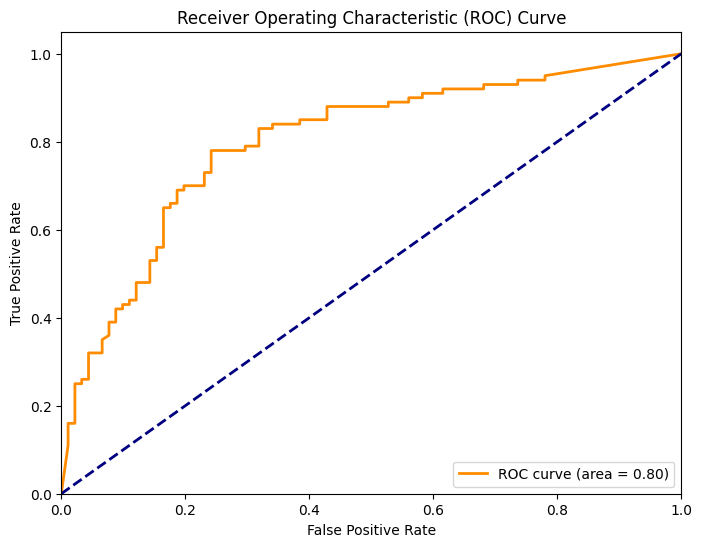

0.7456357553054215

In [ ]:
get_roc(y_test_local, knn_proba)

In [ ]:
knn = grid_search.best_estimator_
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
df = pd.DataFrame(knn_pred, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("knn_submission.csv")

In [ ]:
grid_search.fit(X=X_train_lda, y=y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30, 2),
                         'weights': ['uniform', 'distance']})

0 - {'n_neighbors': 27, 'weights': 'uniform'} - AggP: 0.8197464866354368
1 - {'n_neighbors': 29, 'weights': 'uniform'} - AggP: 0.8187214108569855
2 - {'n_neighbors': 21, 'weights': 'uniform'} - AggP: 0.8144998622209976
3 - {'n_neighbors': 25, 'weights': 'uniform'} - AggP: 0.8134582529622485
4 - {'n_neighbors': 23, 'weights': 'uniform'} - AggP: 0.8103058693855056
5 - {'n_neighbors': 19, 'weights': 'uniform'} - AggP: 0.8082116285478094


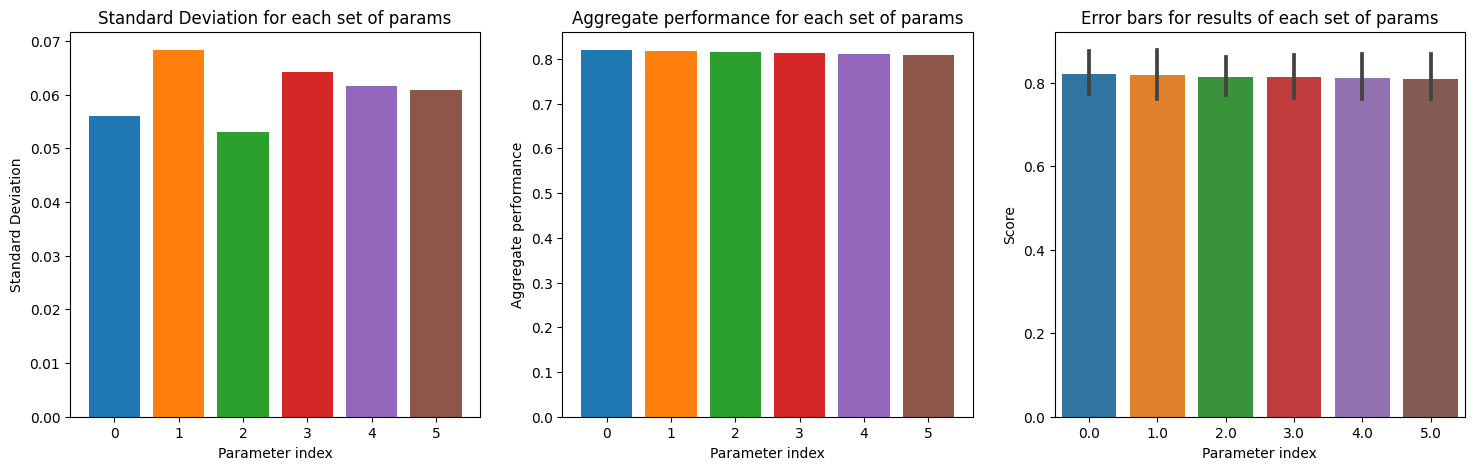

In [ ]:
knn_lda_cv_res = grid_search.cv_results_
splits = analyze_grid_results(knn_lda_cv_res, n_max_params=6)

In [ ]:
print(f"Best aggregate performance: %.2f" %(grid_search.best_score_))
print("From model:")
grid_search.best_estimator_

Best aggregate performance: 0.82
From model:


KNeighborsClassifier(n_neighbors=27)

Accuracy score: 0.78
Survivors precision: 0.72
Survivors recall: 0.87
Deceased precision: 0.85
Deceased recall: 0.70


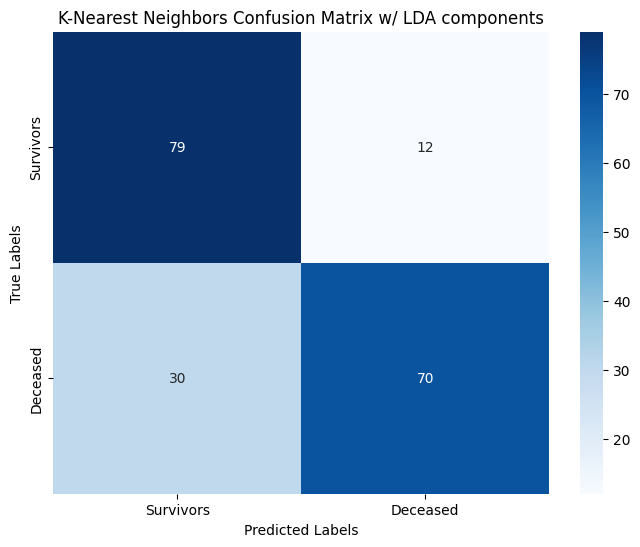

In [ ]:
knn_lda = grid_search.best_estimator_
knn_lda.fit(X_train_local_lda, y_train_local)
knn_lda_pred = knn_lda.predict(X_test_local_lda)
knn_lda_proba = knn_lda.predict_proba(X_test_local_lda)[:,1]
eval_predictions(knn_lda_pred, y_test_local, title="K-Nearest Neighbors Confusion Matrix w/ LDA components")

Precision and recall scores for survivors and deceased are similar and well-balanced, indicating a moderate level of bias in the model. The somewhat lower precision and recall scores in comparison to accuracy indicate a moderate level of variance, implying there is room for improvement in correctly identifying true positives and reducing false negatives.

The threshold for the given allowed_fpr is: 0.4444
Resulting in a tpr of: 0.7800


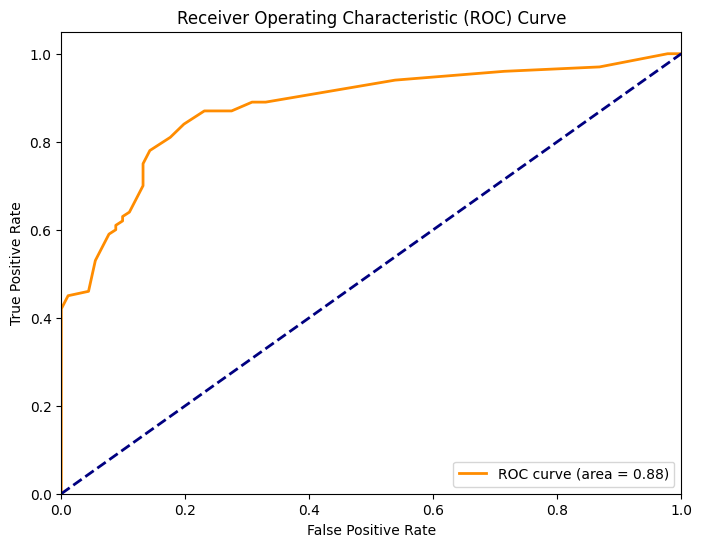

0.4444444444444444

In [ ]:
get_roc(y_test_local, knn_lda_proba)

In [ ]:
knn_lda = grid_search.best_estimator_
knn_lda.fit(X_train_lda, y_train)
knn_lda_pred = knn_lda.predict(X_test_lda)
df = pd.DataFrame(knn_lda_pred, index=X_test.index, columns=["Survived"]) #, index=X_test.index
df.index.name = "PassengerId"
df.to_csv("knn_lda_submission.csv")

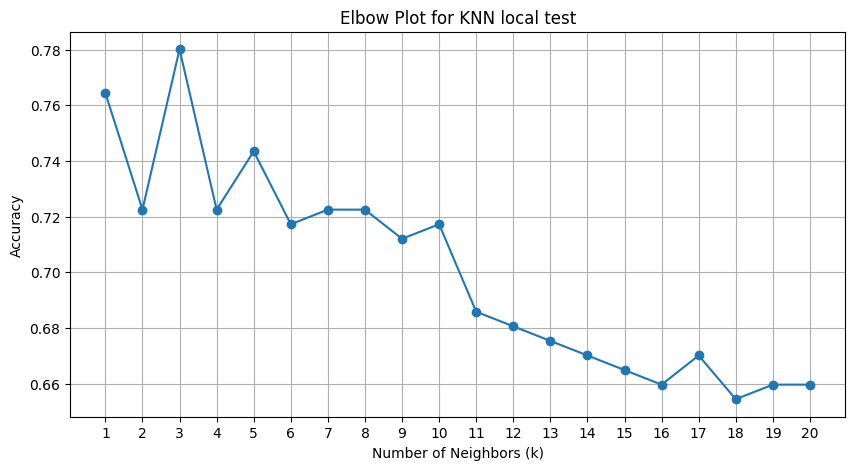

In [ ]:
k_values = []
accuracy_scores = []
k_range = range(1, 21)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_local, y_train_local)

    accuracy = knn.score(X_test_local, y_test_local)

    k_values.append(k)
    accuracy_scores.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Elbow Plot for KNN local test')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

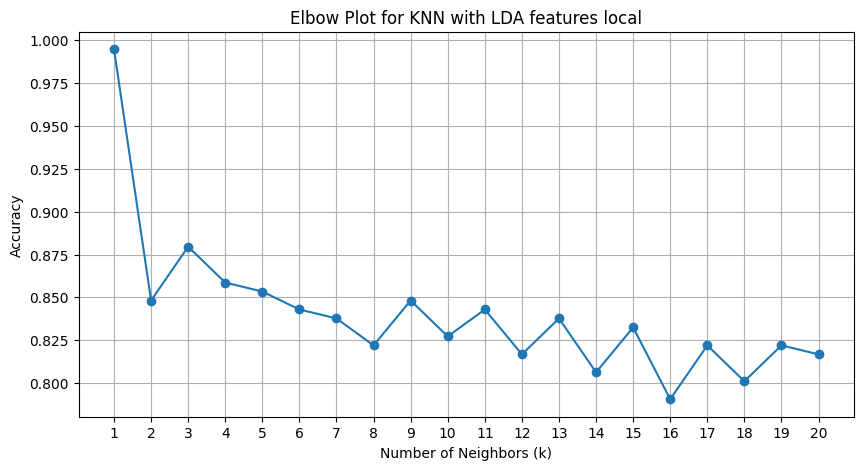

In [ ]:
k_values = []
accuracy_scores = []
k_range = range(1, 21)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_lda, y_train)

    accuracy = knn.score(X_test_local_lda, y_test_local)

    k_values.append(k)
    accuracy_scores.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Elbow Plot for KNN with LDA features local')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### PyTorch

We are also implementing an straightforward PyTorch feedforward binary classifier model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

The ClassifierNetwork is a simple and effective PyTorch feedforward binary classifier model. Composed of an input layer, two hidden layers, and an output layer, designed to handle binary classification tasks efficiently. The use of multiple hidden layers allows the model to learn patterns and relationships in the data, while the ReLU activation functions introduce non-linearity. The final output layer utilizes a sigmoid activation function to produce probability scores for binary classification, ensuring that predictions fall within "0" or "1" . The forward function performs forward propagation, applying the specified activation functions to transform input data, producing a classification.

In [ ]:
class ClassifierNetwork(nn.Module):
    def __init__(self, input_layer_dims, hidden_layer_dims, output_layer_dims):
        super(ClassifierNetwork, self).__init__()
        self.input_layer = nn.Linear(input_layer_dims, hidden_layer_dims)
        self.hidden_layer = nn.Linear(hidden_layer_dims, hidden_layer_dims)
        self.hidden_layer_two = nn.Linear(hidden_layer_dims, hidden_layer_dims)
        self.output_layer = nn.Linear(hidden_layer_dims, output_layer_dims)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        x = F.relu(self.hidden_layer_two(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

The train_classifier function is cresponsible for training the model on the training dataset. It iterates through batches of training data, computes the loss using a specified criterion, performs backpropagation to update model's weights with the optimizer, and keeps track of  cumulative loss. After processing all batches, it returns an average training loss, providing insight into how well the model is learning from the training data.

The evaluate_classifier function checks the model's performance on a separate test dataset. Computes accuracy, average loss, predicted labels, and predicted probabilities. It also calculates the probabilities for both class 0 and class 1 using the sigmoid function, enabling the calculation of metrics such as the Area Under Curve (ROC-AUC). The function ensures that the model's evaluation is performed in an evaluation mode (model.eval()).

In [ ]:
def train_classifier(model, X_train, y_train, criterion, optimizer, train_loader):
    model.train()
    curr_loss = 0.0
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        curr_loss += loss.item()

    average_loss = curr_loss / len(X_train)
    return average_loss

def evaluate_classifier(model, X_test, y_test, criterion):
    model.eval()

    correct = 0
    total = 0
    curr_loss = 0.0
    predicted_labels = []
    predicted_probabilities = []

    with torch.no_grad():
        for X, y in zip(X_test, y_test):
            outputs = model(X)
            loss = criterion(outputs, y)

            probability_class_1 = torch.sigmoid(outputs).item()
            probability_class_0 = 1 - probability_class_1
            predicted_probabilities.append([probability_class_0, probability_class_1])

            predicted = round(outputs.item())
            predicted_labels.append(predicted)

            #_, predicted = torch.max(outputs.data, 1)
            predicted = round(outputs.item())

            total += y.size(0)
            correct += (predicted == y).sum().item()
            curr_loss += loss.item()
    accuracy = 100 * correct / total
    average_loss = curr_loss / len(X_test)
    return accuracy, average_loss, predicted_labels, predicted_probabilities
def predictTorch(model, X_test_t):
    outputs = []
    with torch.no_grad():
        for X in X_test_t:
            output = model(X)
            print(round(output.item()))
            outputs.append(round(output.item()))
    return outputs

In [ ]:
X_train_model = torch.tensor(X_train_local.to_numpy(), dtype=torch.float32)
X_test_model = torch.tensor(X_test_local.to_numpy(), dtype=torch.float32)
X_test_model_kaggle = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_model = torch.tensor(y_train_local.to_numpy(), dtype=torch.float32).reshape(-1, 1)
y_test_model = torch.tensor(y_test_local.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [ ]:
X_train.shape[1]

22

The use of the Binary Cross-Entropy Loss (BCELoss) as the criterion is suited for binary classification problems, as it measures the dissimilarity between predicted probabilities and actual labels. The model architecture consists of 11 input features, two hidden layers with 128 units each, and a single output layer. The Adam optimizer with a learning rate of 0.0001 efficiently updates the model's weights during training. Additionally, the batch size of 32 and data shuffling in the DataLoader contribute to stable and effective optimization, ensuring that the model generalizes well to unseen data.

In [ ]:
criterion = nn.BCELoss()
model = ClassifierNetwork(X_train_local.shape[1], 128, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_dataset = TensorDataset(X_train_model, y_train_model)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 110
for epoch in range(num_epochs):
    train_loss = train_classifier(model, X_train_model, y_train_model, criterion, optimizer, train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}")

Epoch 1/110 - Train Loss: 0.0225
Epoch 2/110 - Train Loss: 0.0206
Epoch 3/110 - Train Loss: 0.0208
Epoch 4/110 - Train Loss: 0.0212
Epoch 5/110 - Train Loss: 0.0201
Epoch 6/110 - Train Loss: 0.0201
Epoch 7/110 - Train Loss: 0.0200
Epoch 8/110 - Train Loss: 0.0200
Epoch 9/110 - Train Loss: 0.0210
Epoch 10/110 - Train Loss: 0.0203
Epoch 11/110 - Train Loss: 0.0200
Epoch 12/110 - Train Loss: 0.0205
Epoch 13/110 - Train Loss: 0.0199
Epoch 14/110 - Train Loss: 0.0200
Epoch 15/110 - Train Loss: 0.0200
Epoch 16/110 - Train Loss: 0.0197
Epoch 17/110 - Train Loss: 0.0201
Epoch 18/110 - Train Loss: 0.0203
Epoch 19/110 - Train Loss: 0.0199
Epoch 20/110 - Train Loss: 0.0199
Epoch 21/110 - Train Loss: 0.0197
Epoch 22/110 - Train Loss: 0.0196
Epoch 23/110 - Train Loss: 0.0196
Epoch 24/110 - Train Loss: 0.0207
Epoch 25/110 - Train Loss: 0.0200
Epoch 26/110 - Train Loss: 0.0195
Epoch 27/110 - Train Loss: 0.0197
Epoch 28/110 - Train Loss: 0.0194
Epoch 29/110 - Train Loss: 0.0196
Epoch 30/110 - Train Lo

In [ ]:
accuracy, test_loss, predicted_labels, predicted_probabilities = evaluate_classifier(model, X_test_model, y_test_model, criterion)
print(f"Test Accuracy: {accuracy:.2f}% - Test Loss: {test_loss:.4f}")

Test Accuracy: 72.25% - Test Loss: 0.5588


In [ ]:
predicted_probabilities = predicted_probabilities

The results from our PyTorch model dont show promising performance with a test accuracy of 62.25% and a test loss of 0.6822. When we evaluated the predictions using a confusion matrix, we found that our model achieved balanced precision and recall scores of 0.62 for both survivors and deceased passengers. This indicates that our PyTorch model is effectively classifying passengers' survival status with equal precision and recall, contributing to an overall robust performance.

Accuracy score: 0.72
Survivors precision: 0.74
Survivors recall: 0.65
Deceased precision: 0.71
Deceased recall: 0.79


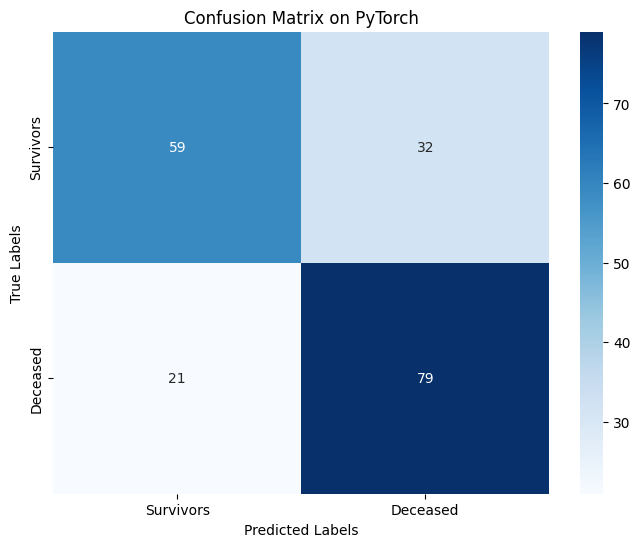

In [ ]:
eval_predictions(predicted_labels, y_test_model, title="Confusion Matrix on PyTorch")

In [ ]:
outputs = predictTorch(model, X_test_model_kaggle)
df = pd.DataFrame(outputs, index=X_test.index, columns=["Survived"])
df.index.name = "PassengerId"
df.to_csv("torch_submission.csv")

0
0
0
0
1
0
1
1
1
1
0
0
1
0
1
1
0
0
1
1
1
0
1
1
1
1
1
0
1
1
1
0
1
1
0
0
1
0
0
1
1
1
0
1
1
0
0
0
1
1
1
1
1
1
0
1
0
0
0
1
0
0
0
1
1
1
1
1
0
1
1
0
0
0
1
0
0
1
0
1
1
1
1
0
0
0
1
0
1
0
1
0
1
0
0
0
1
0
0
0
1
1
0
0
1
0
0
0
0
0
0
1
1
1
1
1
0
1
0
1
1
1
1
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
1
0
1
0
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
0
1
1
1
0
1
1
0
1
1
0
1
0
1
0
1
0
1
1
1
0
1
0
1
0
0
0
1
1
1
1
0
0
1
0
1
0
0
0
0
1
1
1
1
1
1
0
1
0
1
0
1
1
0
1
0
0
1
1
0
0
1
0
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
0
0
0
1
0
0
0
0
0
1
1
1
0
1
0
0
0
0
0
1
1
0
1
1
0
1
1
0
1
1
1
1
0
0
1
0
0
0
1
0
0
0
0
1
1
1
0
0
0
1
0
1
1
1
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
0
1
1
1
0
1
0
0
1
0
1
0
1
0
0
0
0
1
1
1
0
0
1
0
1
1
0
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
0
1
1
0
1
1
0
0
0
1
0
0
1
1
1
1
0
0
0
1
1
1
1
0
1
1
1
1
0
0
1
0
1
1
0
1
0
1
1
1
1
1
0
0
1
0
0
1


## Conclusion


Although various models with similar results were trained, only a handful of models displayed a competent accuracy when tested with Kaggle. This models where KNN, Gaussian Naive Bayes and LDA. One common thing that this algorithms share is their overall simplicity. In contrast with our neural network, for example, simple algorithms have shown better results. This might be an indication of the approach we should take with this problem: avoid overfitting and focus on the feature engineering.

The best score with Kaggle, of the three mentioned above, was the one given by Gaussian Naive Bayes, trained with the LDA component. This model gave us a score of 0.7799. We consider this a success, since it's our first time making a project of the sort, ans the state-of-the-art seems to be around the 0.79 range.

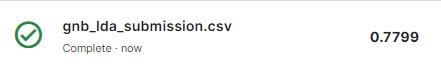

In conclusion, the Titanic project was both challenging and rewarding. We encountered several obstacles, including missing data, which we addressed through imputation and techniques like SMOTE to balance the dataset.

To gain a deeper understanding of the data, we created visualizations like histograms and QQ plots to explore feature distributions. Additionally, we utilized dimensionality reduction methods like PCA and LDA to streamline our dataset for modeling.

A significant aspect of our project was conducting thorough analysis, including exploring correlations and visualizations to uncover hidden data patterns. This exploration enhanced our comprehension of the factors influencing survival on the Titanic.

We saw many different routes we could approach feature engineering: Focus on the features with greater correlation with the target label, create more features to enrich our dataset, handle missing values, and unbalanced data in many ways, etc. In the end, we found this process to be the most relevant part of the whole project.

Despite these challenges, we adapted and employed various techniques, including encoding, and experimented with different models such as LDA, KNN, Random Forest, Naive Bayes, and a PyTorch neural network. Notably, we used KNN imputation to fill missing samples. This project enhanced our skills in data preprocessing, modeling, and visualization, highlighting the importance of comprehensive analysis in extracting valuable insights from data. It serves as a testament to the dynamic field of data science, where each challenge offers an opportunity for growth and learning.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=201ebe51-572d-4ad8-878f-7cdc63f0aa18' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>